In [198]:
# Thư viện cần thiết
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.errors import SettingWithCopyWarning
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2, stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import scikitplot as skplt
from yellowbrick.model_selection import FeatureImportances
import joblib
import os

In [199]:
# Import Datasets
cc_data_full_data = pd.read_csv('datasets/application_record.csv')      # Thông tin ứng viên
credit_status = pd.read_csv('datasets/credit_record.csv')               # Thông tin thẻ tín dụng

## Thông tin ứng viên

In [200]:
cc_data_full_data.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0         427500.00               Working               Higher education   
1         427500.00               Working               Higher education   
2         112500.00               Working  Secondary / secondary special   
3         270000.00  Commercial associate  Secondary / secondary special   
4         270000.00  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0             2.00  
1             2.00  
2             2.00  
3             1.00  
4             1.00

## Thông tin thẻ tín dụng của ứng viên

In [201]:
credit_status.head()

ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C

# KHAI PHÁ VÀ PHÂN TÍCH DỮ LIỆU

## Khởi tạo biến mục tiêu:
> Dựa trên điều kiện khách hàng quá hạn 60 ngày (được gán nhãn)

In [202]:
# Tính độ tuổi tài khoản của mỗi khách hàng
begin_month = pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month = begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data = pd.merge(cc_data_full_data, begin_month, how='left', on='ID')

# Xác định khách hàng có rủi ro tín dụng cao
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] == '2'] = 'Yes'
credit_status['dep_value'][credit_status['STATUS'] == '3'] = 'Yes'
credit_status['dep_value'][credit_status['STATUS'] == '4'] = 'Yes'
credit_status['dep_value'][credit_status['STATUS'] == '5'] = 'Yes'
cpunt = credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0] = 'Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0] = 'No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data, cpunt, how='inner', on='ID')

# Cột mục tiêu "Is high risk"
cc_data_full_data['Is high risk'] = cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk'] = 1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk'] = 0
cc_data_full_data.drop('dep_value', axis=1, inplace=True)
pd.options.mode.chained_assignment = None           # Ẩn cảnh báo

In [203]:
cc_data_full_data.head()

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0         427500.00               Working               Higher education   
1         427500.00               Working               Higher education   
2         112500.00               Working  Secondary / secondary special   
3         270000.00  Commercial associate  Secondary / secondary special   
4         270000.00  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  Account age Is high risk  
0             2.00       -15.00            0  
1             2.00       -14.00            0  
2             2.00       -29.00            0  
3             1.00        -4.00            0  
4             1.00       -26.00            0

In [204]:
# Đổi tên thuộc tính
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

## Chuẩn bị dữ liệu huấn luyện mô hình
> Sử dụng cc_data_full_data để chia ra làm 80% tập train và 20% tập test

In [205]:
# Phân tách dữ liệu
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [206]:
# Dữ liệu tập Train và tập Test
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

In [207]:
# Kiểm tra số chiều của hai tập
print(f"DimTrain = {cc_train_original.shape}")
print(f"DimTest = {cc_test_original.shape}")

DimTrain = (29165, 20)
DimTest = (7292, 20)


In [208]:
# Xuất file.csv của tập train và tập test
cc_train_original.to_csv('datasets/train.csv', index = False)
cc_test_original.to_csv('datasets/test.csv', index = False)

In [209]:
# Sao chép dữ liệu train và test để làm việc
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

In [210]:
# Tổng quan dữ liệu
cc_data_full_data.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0 427500.00   
1  5008805      M         Y              Y               0 427500.00   
2  5008806      M         Y              Y               0 112500.00   
3  5008808      F         N              Y               0 270000.00   
4  5008809      F         N              Y               0 270000.00   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count  Account age Is high risk  
0                 2.00       -15.00            0  
1                 2.00       -14.00            0  
2                 2.00       -29.00            0  
3                 1.00        -4.00            0  
4                 1.00       -26.00            0

In [211]:
# Thông tin chi tiết bộ dữ liệu
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [212]:
# Cung cấp thông tin thống kê
cc_data_full_data.describe()

ID  Children count     Income       Age  Employment length  \
count   36457.00        36457.00   36457.00  36457.00           36457.00   
mean  5078227.00            0.43  186685.74 -15975.17           59262.94   
std     41875.24            0.74  101789.23   4200.55          137651.33   
min   5008804.00            0.00   27000.00 -25152.00          -15713.00   
25%   5042028.00            0.00  121500.00 -19438.00           -3153.00   
50%   5074614.00            0.00  157500.00 -15563.00           -1552.00   
75%   5115396.00            1.00  225000.00 -12462.00            -408.00   
max   5150487.00           19.00 1575000.00  -7489.00          365243.00   

       Has a mobile phone  Has a work phone  Has a phone  Has an email  \
count            36457.00          36457.00     36457.00      36457.00   
mean                 1.00              0.23         0.29          0.09   
std                  0.00              0.42         0.46          0.29   
min                  1.00              0.00         0.00          0.00   
25%                  1.00              0.00         0.00          0.00   
50%                  1.00              0.00         0.00          0.00   
75%                  1.00              0.00         1.00          0.00   
max                  1.00              1.00         1.00          1.00   

       Family member count  Account age  
count             36457.00     36457.00  
mean                  2.20       -26.16  
std                   0.91        16.50  
min                   1.00       -60.00  
25%                   2.00       -39.00  
50%                   2.00       -24.00  
75%                   3.00       -12.00  
max                  20.00         0.00

## Thống kê dữ liệu dạng biểu đồ
> Tìm kiếm thuộc tính mất mát thông tin

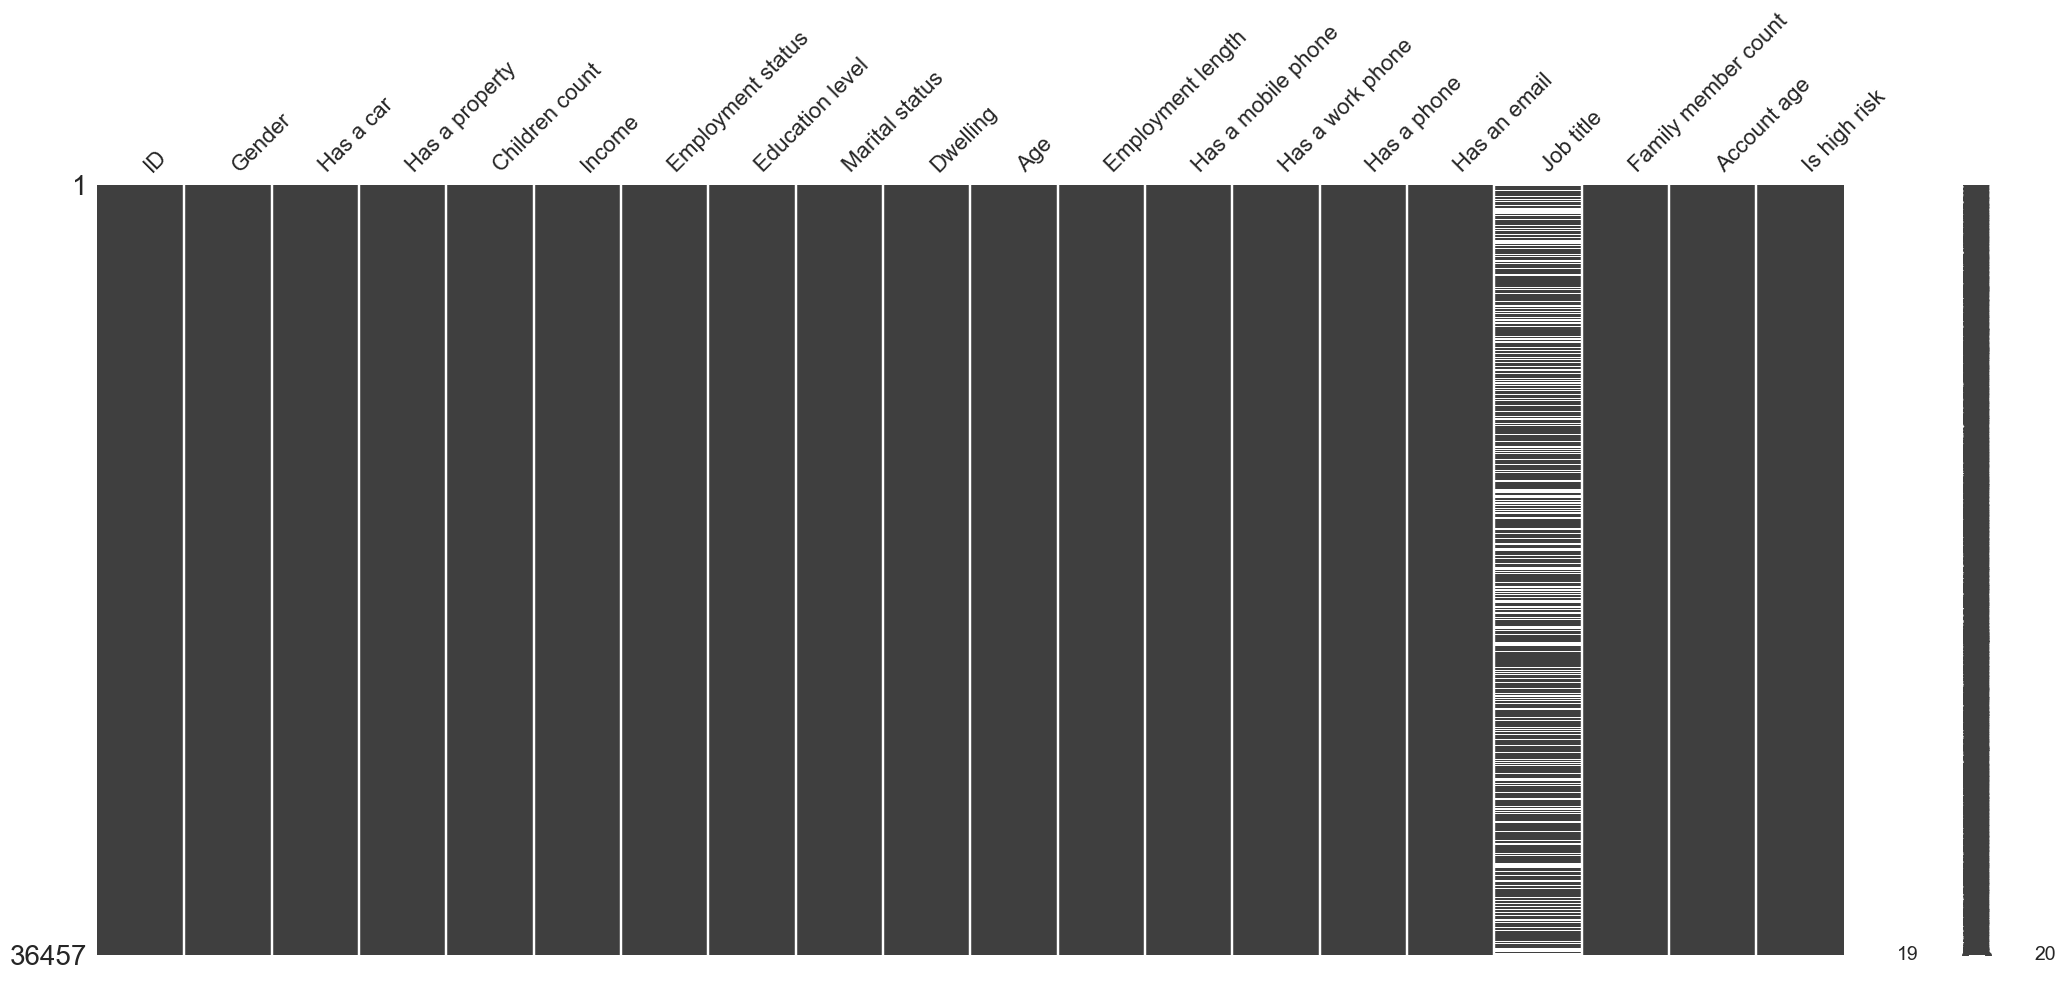

In [213]:
# Sử dụng Missingno trực quan hóa giá trị của thuộc tính (Job title mất mát giá trị)
msno.matrix(cc_data_full_data)
plt.show()

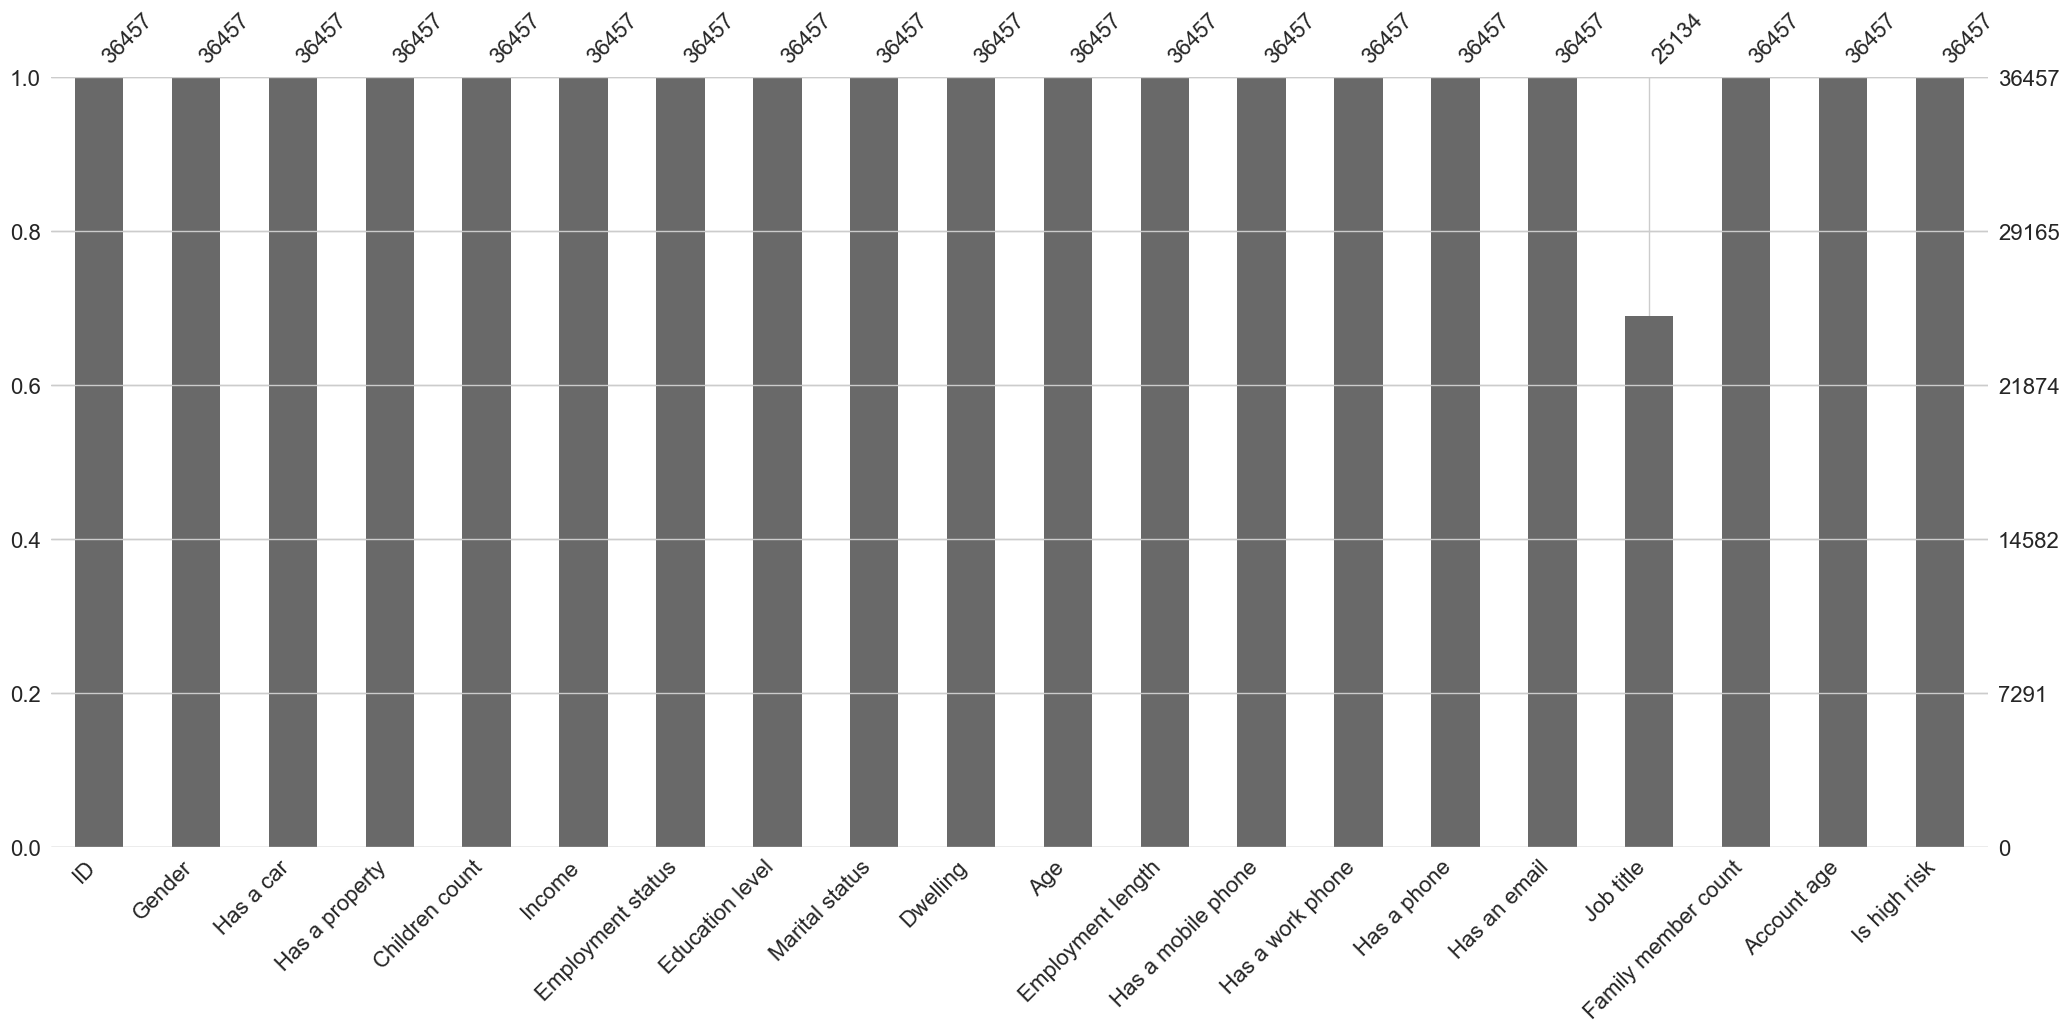

In [214]:
# Trực quan hóa dữ liệu chi tiết
msno.bar(cc_data_full_data)
plt.show()

## Phân tích dữ liệu
1. Tính số lượng và tần suất xuất hiện của đặc trưng thuộc tính

2. Mô tả thông tin dữ liệu thống kê của từng đặc trưng thuộc tính:
+ Tính số lượng của từng lớp trong một đặc trưng cùng với tần suất của nó
+ Mô tả thông tin dữ liệu thống kê của từng đặc trưng thuộc tính

3. Vẽ biểu đồ và đồ thị trực quan hóa dữ liệu:
+ Biểu đồ tròn (pie plot): trực quan hóa tỷ lệ phân bổ các lớp trong đặc trưng
+ Biểu đồ cột (bar plot): so sánh số lượng các lớp trong đặc trưng
+ Biểu đồ hộp (box plot): phân tích phân phối và các giá trị ngoại lai trong đặc trưng
+ Biểu đồ histogram (hist plot): phân tích sự phân bố các đặc trưng 

4. Phân tích đơn biến, đa biến, phương sai

### Phân tích đơn biến (Univariate analysis):

In [215]:
# Thư viện cần thiết
from functions.data_analysis import gen_info_feat
from functions.draw_dataset import create_bar_plot, create_pie_plot, create_box_plot, create_hist_plot
from functions.draw_plot_high_risk import low_high_risk_box_plot, low_high_risk_bar_plot

#### Đặc trưng Gender (giới tính)

In [216]:
# Phân tích dữ liệu đơn biến Gender
gen_info_feat(cc_train_copy, 'Gender', cc_test_copy)

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
        Count  Frequency (%)
Gender                      
F       19549          67.03
M        9616          32.97


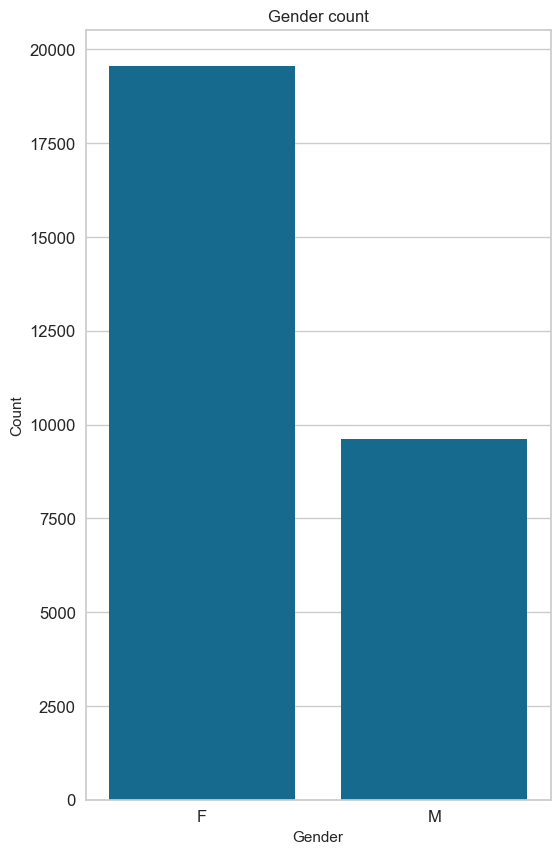

In [217]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Gender')

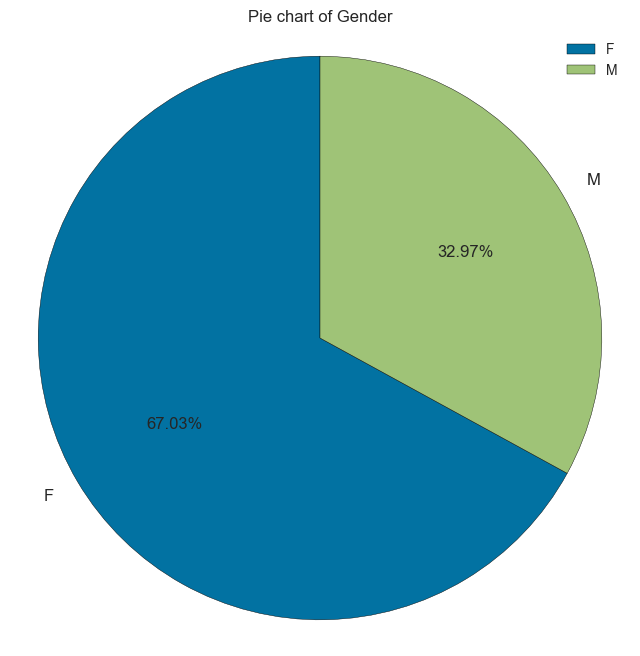

In [218]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Gender')

### Đặc trưng Age (độ tuổi khách hàng)

In [219]:
# Phân tích dữ liệu đơn biến Age
gen_info_feat(cc_train_copy, 'Age', cc_test_copy)

Description:
count   29165.00
mean       43.75
std        11.51
min        21.10
25%        34.15
50%        42.61
75%        53.23
max        68.86
Name: Age, dtype: float64
**************************************************
Object type:int64
Description:
count    29165.00
mean    -15979.48
std       4203.00
min     -25152.00
25%     -19444.00
50%     -15565.00
75%     -12475.00
max      -7705.00
Name: Age, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
        Count  Frequency (%)
Age                         
-15519     44           0.15
-12676     44           0.15
-16896     33           0.11
-16768     26           0.09
-16053     26           0.09
...       ...            ...
-9235       1           0.00
-16968      1           0.00
-15714      1           0.00
-10718      1           0.00
-17757      1           0.00

[6794 rows x 2 columns]


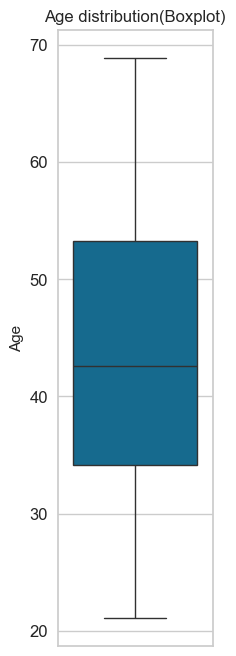

In [220]:
# Vẽ biểu đồ hộp
create_box_plot(cc_train_copy, 'Age', cc_train_copy)

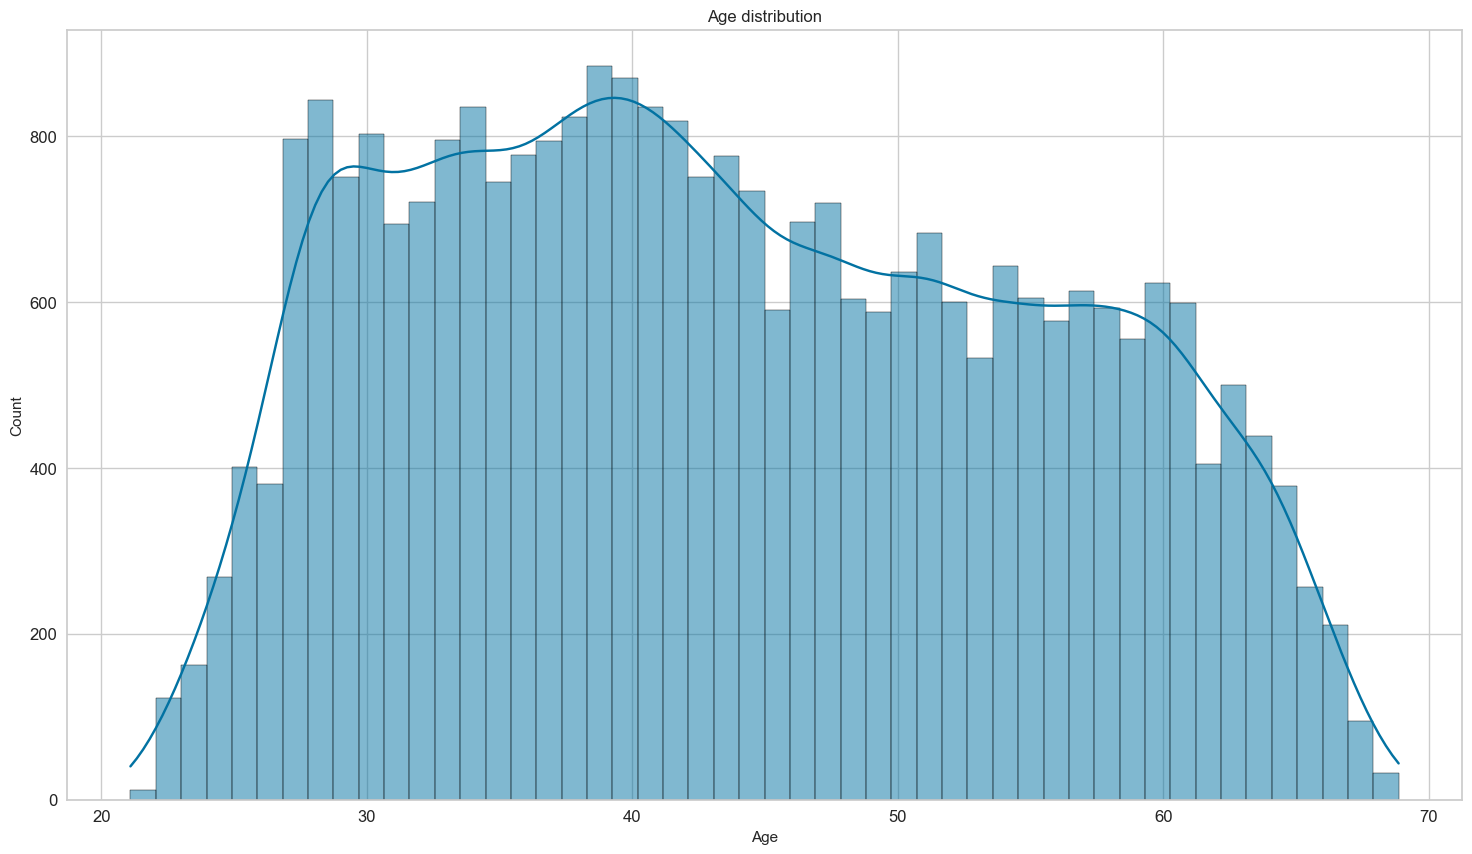

In [221]:
# Vẽ biểu đồ histogram
create_hist_plot(cc_train_copy, 'Age', cc_train_copy)

Is high risk
0   43.75
1   43.54
Name: Age, dtype: float64


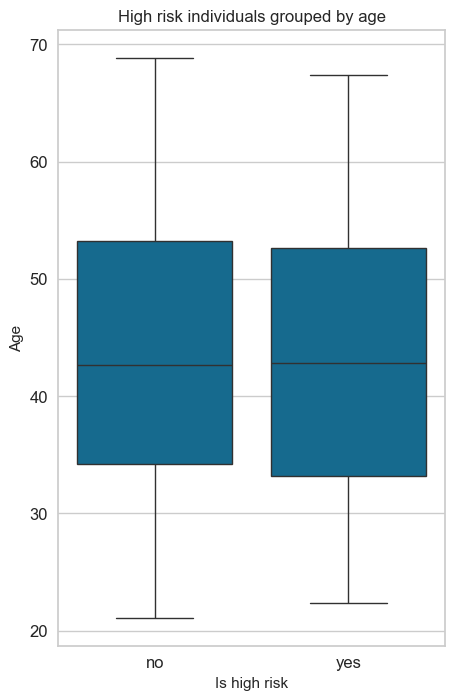

In [222]:
# So sánh giữa hai đặc trưng Age và IsHighRisk (độ rủi ro dựa vào độ tuổi khách hàng)
low_high_risk_box_plot(cc_train_copy, 'Age', cc_train_copy)

### Đặc trưng Marital status (tình trạng hôn nhân)

In [223]:
# Phân tích dữ liệu đơn biến Marital status
gen_info_feat(cc_train_copy, 'Marital status', cc_train_copy)

Description:
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Marital status                            
Married               20044          68.73
Single / not married   3864          13.25
Civil marriage         2312           7.93
Separated              1712           5.87
Widow                  1233           4.23


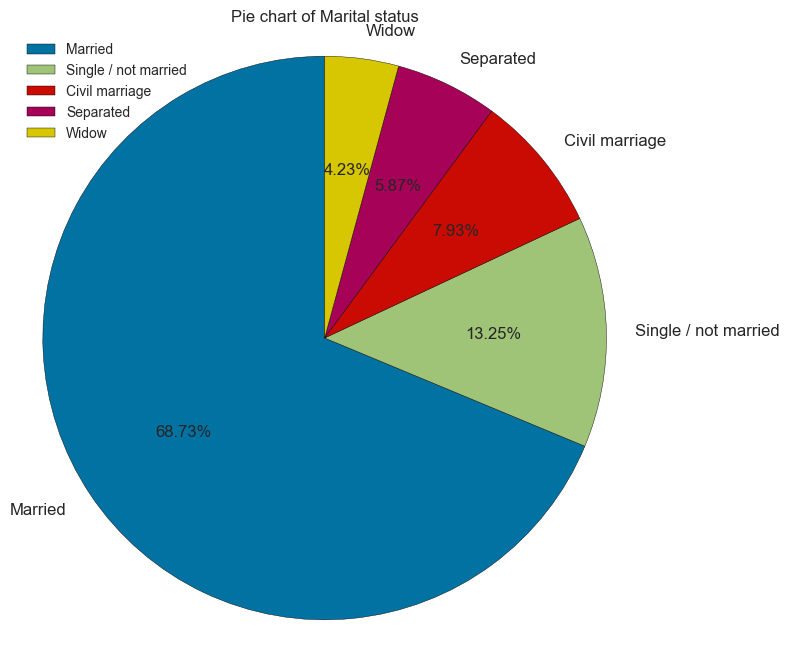

In [224]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Marital status')

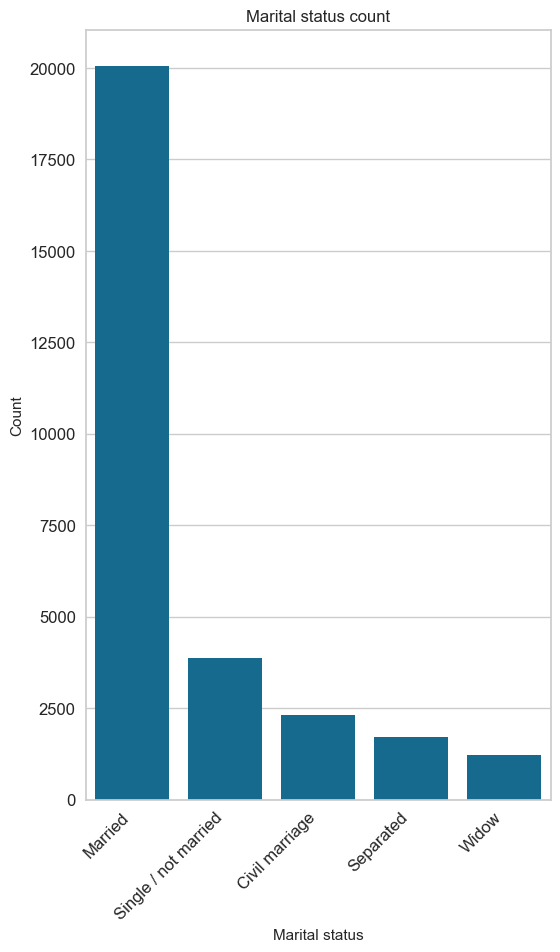

In [225]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Marital status')

{'Married': 320, 'Single / not married': 87, 'Civil marriage': 34, 'Widow': 34, 'Separated': 24}


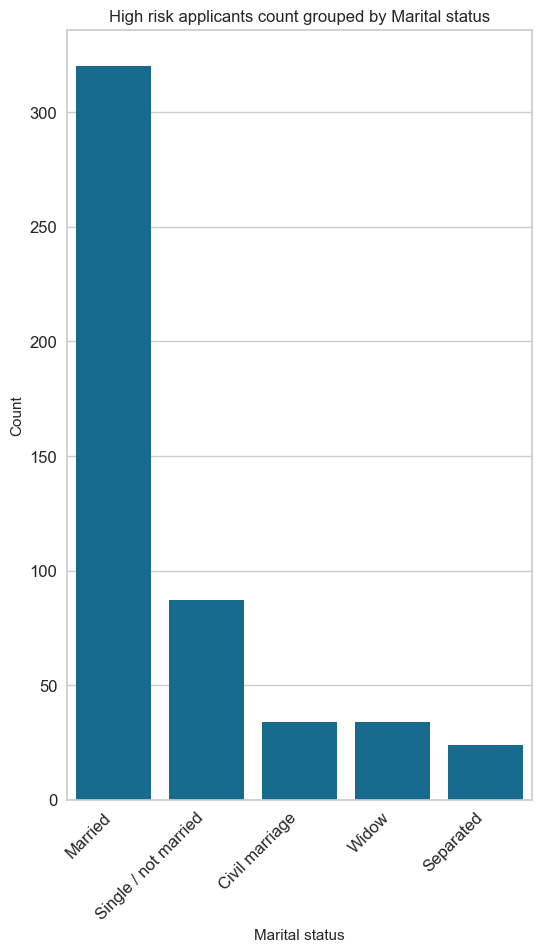

In [226]:
# So sánh giữa hai đặc trưng Marital status và IsHighRisk (độ rủi ro dựa vào tình trạng hôn nhân)
low_high_risk_bar_plot(cc_train_copy, 'Marital status')

### Đặc trưng Family member count (số lượng thành viên trong gia đình)

In [227]:
# Phân tích dữ liệu đơn biến Family member count
gen_info_feat(cc_train_copy, 'Family member count', cc_train_copy)

Description:
count   29165.00
mean        2.20
std         0.91
min         1.00
25%         2.00
50%         2.00
75%         3.00
max        20.00
Name: Family member count, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
                     Count  Frequency (%)
Family member count                      
2.00                 15552          53.32
1.00                  5613          19.25
3.00                  5121          17.56
4.00                  2503           8.58
5.00                   309           1.06
6.00                    48           0.16
7.00                    14           0.05
9.00                     2           0.01
15.00                    2           0.01
20.00                    1           0.00


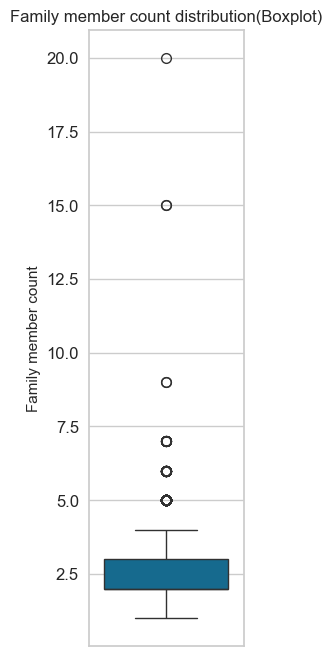

In [228]:
# Vẽ biểu đồ hộp
create_box_plot(cc_train_copy, 'Family member count', cc_train_copy)

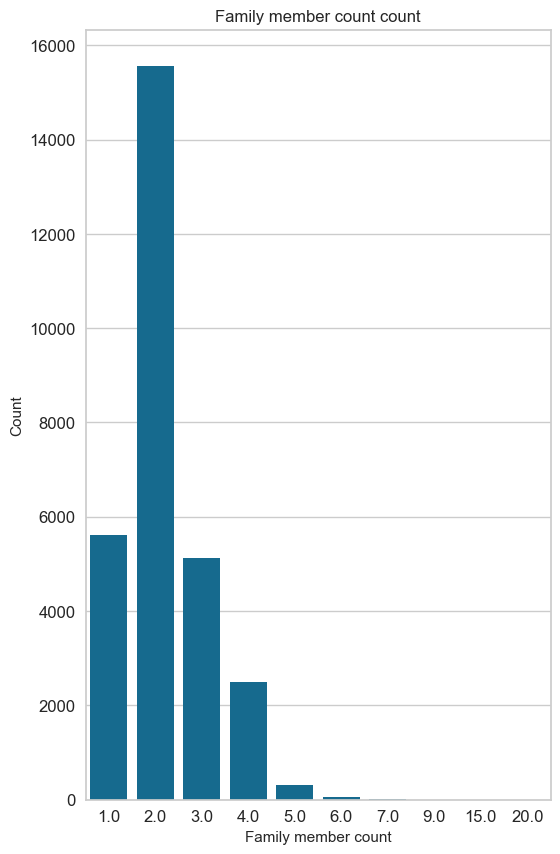

In [229]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Family member count')

### Đặc trưng Children count (số lượng con cái)

In [230]:
# Phân tích dữ liệu đơn biến Children count
gen_info_feat(cc_train_copy, 'Children count', cc_train_copy)

Description:
count   29165.00
mean        0.43
std         0.74
min         0.00
25%         0.00
50%         0.00
75%         1.00
max        19.00
Name: Children count, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                Count  Frequency (%)
Children count                      
0               20143          69.07
1                6003          20.58
2                2624           9.00
3                 323           1.11
4                  52           0.18
5                  15           0.05
7                   2           0.01
14                  2           0.01
19                  1           0.00


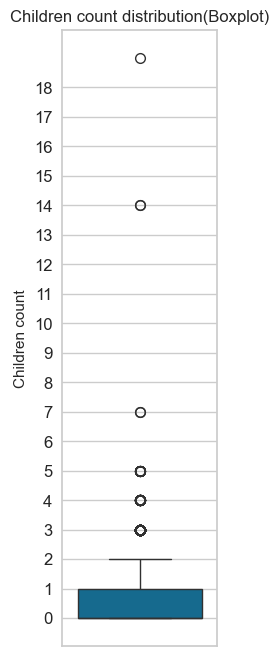

In [231]:
# Vẽ biểu đồ hộp
create_box_plot(cc_train_copy, 'Children count', cc_train_copy)

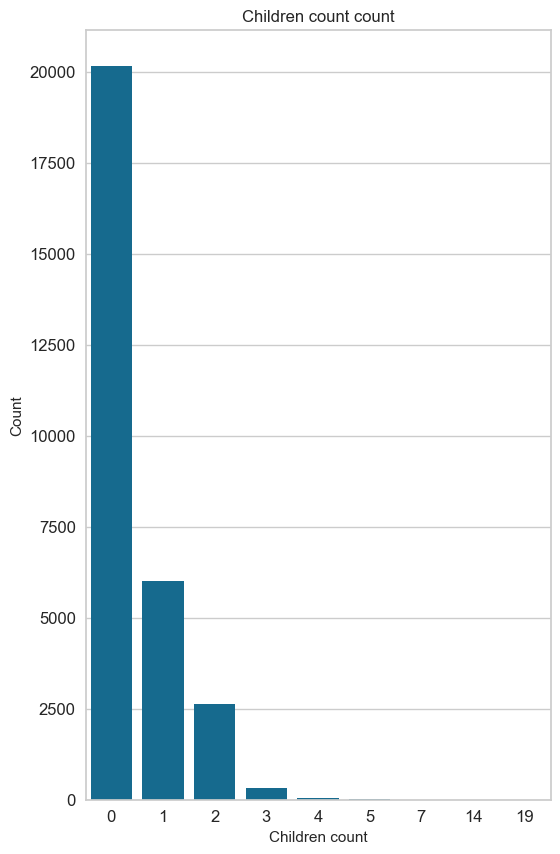

In [232]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Children count')

### Đặc trưng Dwelling type (loại hình nhà ở)

In [233]:
# Phân tích đơn biến Dwelling type
gen_info_feat(cc_train_copy, 'Dwelling', cc_train_copy)

Description:
count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                     Count  Frequency (%)
Dwelling                                 
House / apartment    26059          89.35
With parents          1406           4.82
Municipal apartment    912           3.13
Rented apartment       453           1.55
Office apartment       208           0.71
Co-op apartment        127           0.44


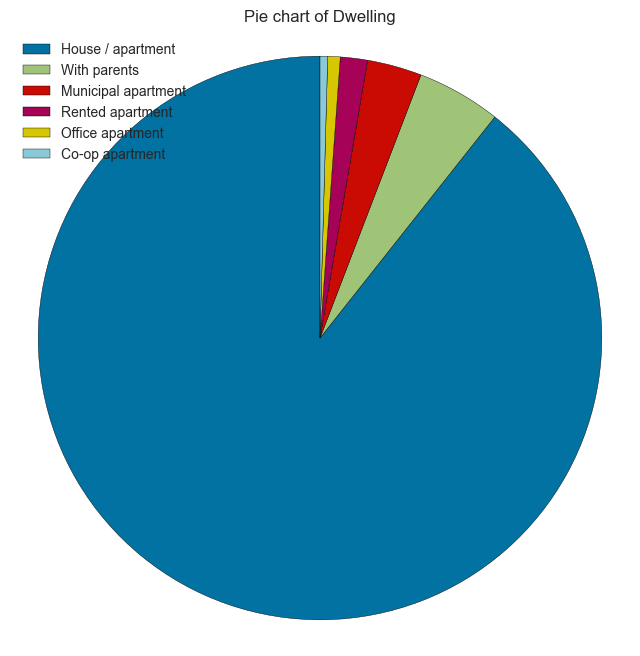

In [234]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Dwelling')

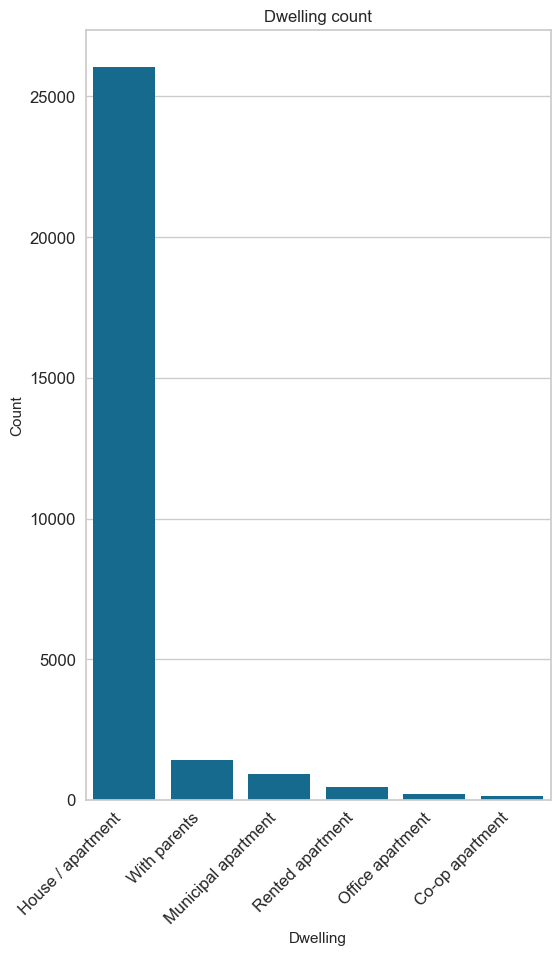

In [235]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Dwelling')

### Đặc trưng Income (thu nhập)

In [236]:
# Phân tích đơn biến Income
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(cc_train_copy, 'Income', cc_train_copy)

Description:
count     29165.00
mean     186890.39
std      101409.64
min       27000.00
25%      121500.00
50%      157500.00
75%      225000.00
max     1575000.00
Name: Income, dtype: float64
**************************************************
Object type:float64


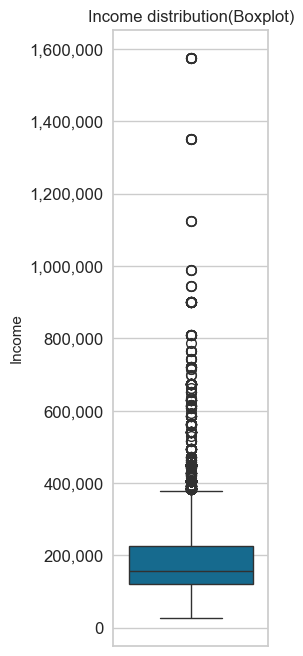

In [237]:
# Vẽ biểu đồ hộp
create_box_plot(cc_train_copy, 'Income', cc_train_copy)

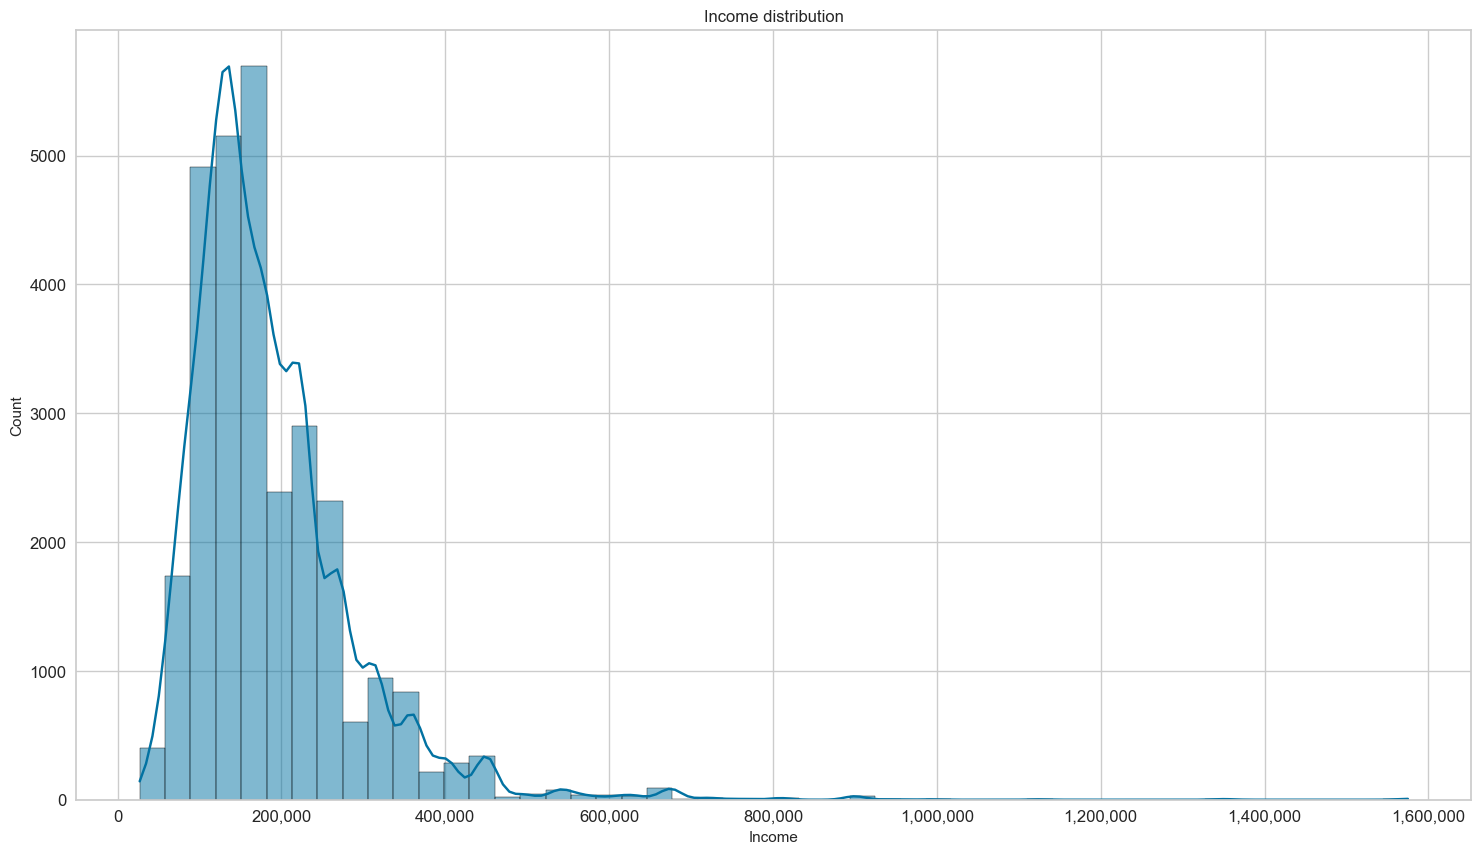

In [238]:
# Vẽ biểu đồ histogram
create_hist_plot(cc_train_copy, 'Income', cc_train_copy)

Is high risk
0   186913.94
1   185537.26
Name: Income, dtype: float64


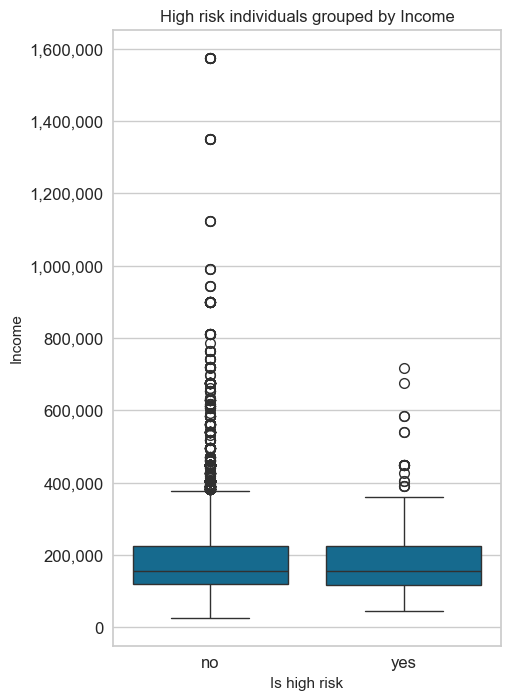

In [239]:
# So sánh giữa hai đặc trưng Income và IsHighRisk (độ rủi ro dựa vào tình trạng thu nhập)
low_high_risk_box_plot(cc_train_copy, 'Income', cc_train_copy)

### Đặc trưng Job title (chức danh công việc)

In [240]:
# Phân tích đơn biến Job title
gen_info_feat(cc_train_copy, 'Job title', cc_train_copy)

Description:
count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Job title                                  
Laborers                5004          24.85
Core staff              2866          14.23
Sales staff             2773          13.77
Managers                2422          12.03
Drivers                 1722           8.55
High skill tech staff   1133           5.63
Accountants              998           4.96
Medicine staff           956           4.75
Cooking staff            521           2.59
Security staff           464           2.30
Cleaning staff           425           2.11
Private service staff    287           1.43
Low-skill Laborers       138           0.69
Waiters/barmen staff     127           0.63
Secretaries              122           0.

In [241]:
# Thống kê dữ liệu bị mất mát của Job title
job_title_nan_count = cc_train_copy['Job title'].isna().sum()
print(f"job_title_nan_count = {job_title_nan_count}")

rows_total_count = cc_train_copy.shape[0]
print(f"rows_total_count = {rows_total_count}")
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

job_title_nan_count = 9027
rows_total_count = 29165
The percentage of missing rows is 30.95 %


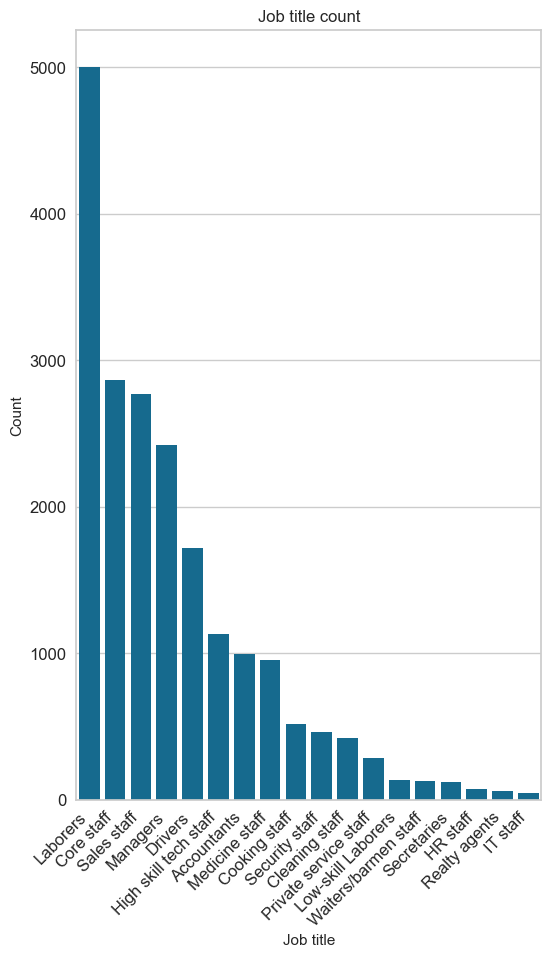

In [242]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Job title')

### Đặc trưng Employment status (tình trạng việc làm)

In [243]:
# Phân tích đơn biến Employment status
gen_info_feat(cc_train_copy, 'Employment status', cc_train_copy)

Description:
count       29165
unique          5
top       Working
freq        15056
Name: Employment status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Employment status                         
Working               15056          51.62
Commercial associate   6801          23.32
Pensioner              4920          16.87
State servant          2381           8.16
Student                   7           0.02


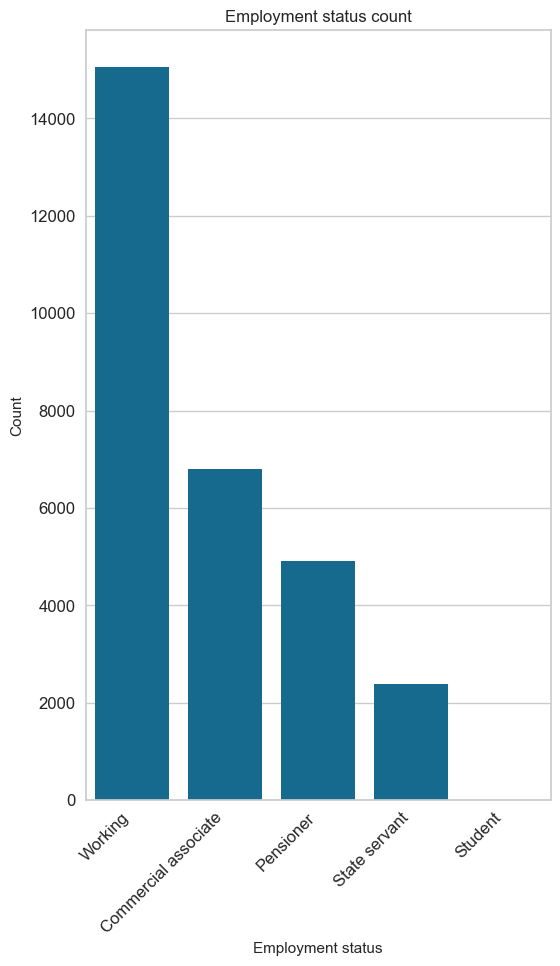

In [244]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Employment status')

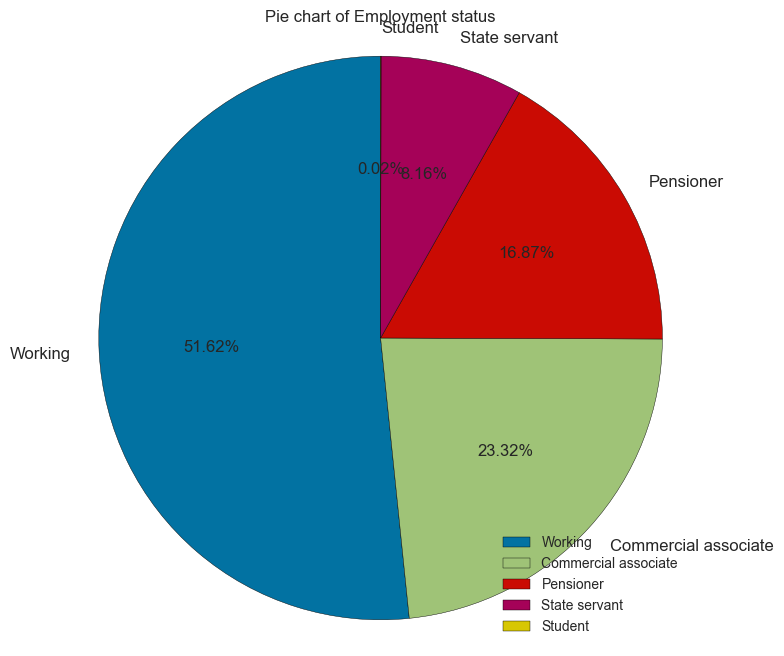

In [245]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Employment status')

### Đặc trưng Education level (trình độ học vấn)

In [246]:
# Phân tích đơn biến Education level
gen_info_feat(cc_train_copy, 'Education level', cc_train_copy)

Description:
count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                               Count  Frequency (%)
Education level                                    
Secondary / secondary special  19803          67.90
Higher education                7910          27.12
Incomplete higher               1129           3.87
Lower secondary                  298           1.02
Academic degree                   25           0.09


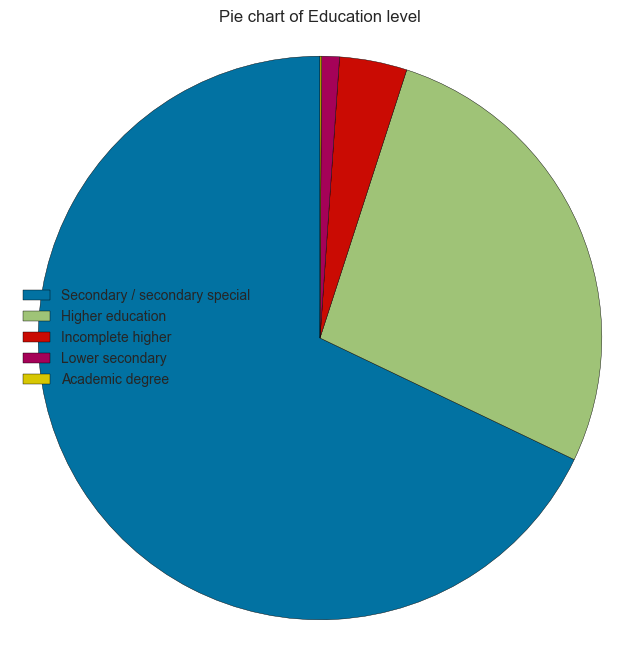

In [247]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Education level')

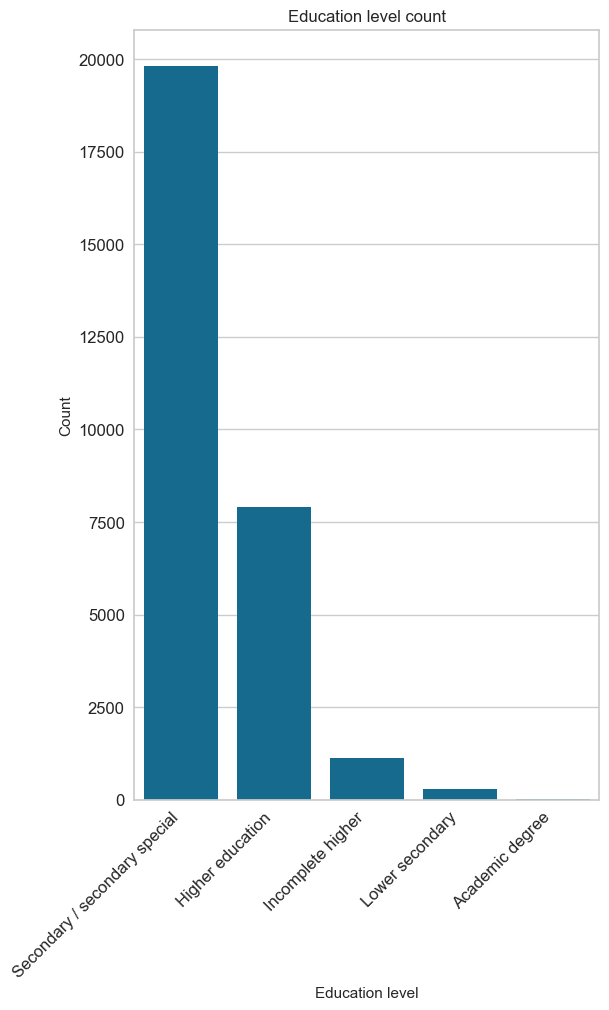

In [248]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Education level')

### Đặc trưng Employment length (thời gian làm việc)

In [249]:
# Phân tích đơn biến Employment length
gen_info_feat(cc_train_copy, 'Employment length', cc_train_copy)

Description:
count   24257.00
mean        7.26
std         6.46
min         0.05
25%         2.68
50%         5.45
75%         9.60
max        43.02
Name: Employment length, dtype: float64
**************************************************
Object type:int64
Description:
count    29165.00
mean     59257.76
std     137655.88
min     -15713.00
25%      -3153.00
50%      -1557.00
75%       -412.00
max     365243.00
Name: Employment length, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                   Count  Frequency (%)
Employment length                      
 365243             4908          16.83
-401                  61           0.21
-200                  55           0.19
-2087                 53           0.18
-1539                 51           0.17
...                  ...            ...
-79                    1           0.00
-13456                 1           0.00
-1417      

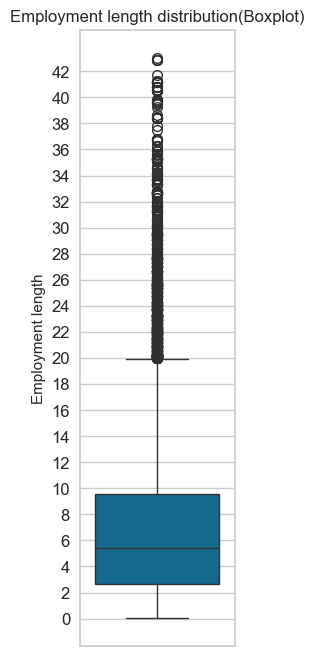

In [250]:
# Vẽ biểu đồ hộp
create_box_plot(cc_train_copy, 'Employment length', cc_train_copy)

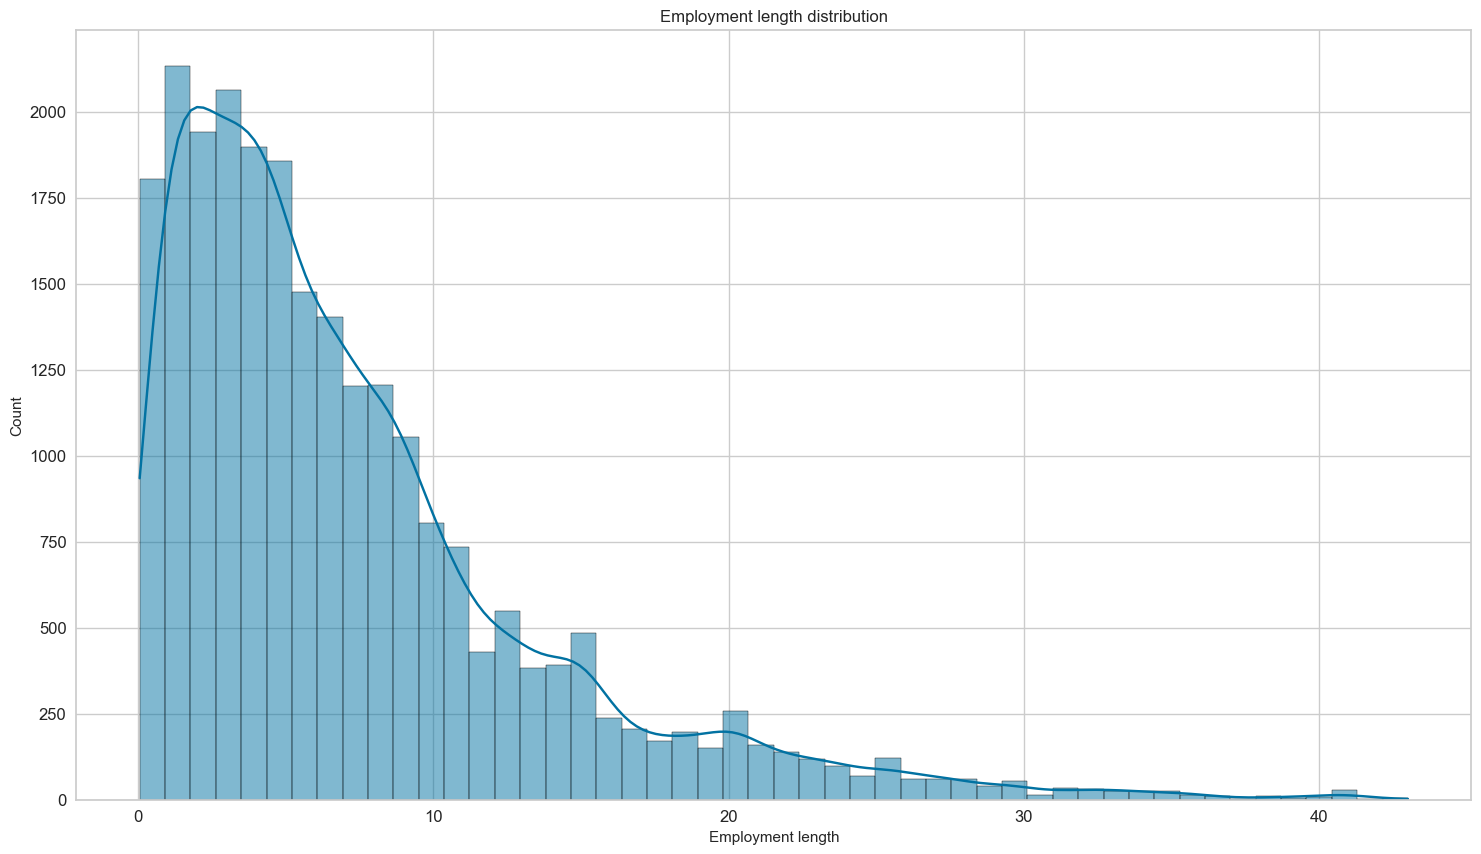

In [251]:
# Vẽ biểu đồ histogram
create_hist_plot(cc_train_copy, 'Employment length', cc_train_copy)

Is high risk
0   7.29
1   5.75
Name: Employment length, dtype: float64


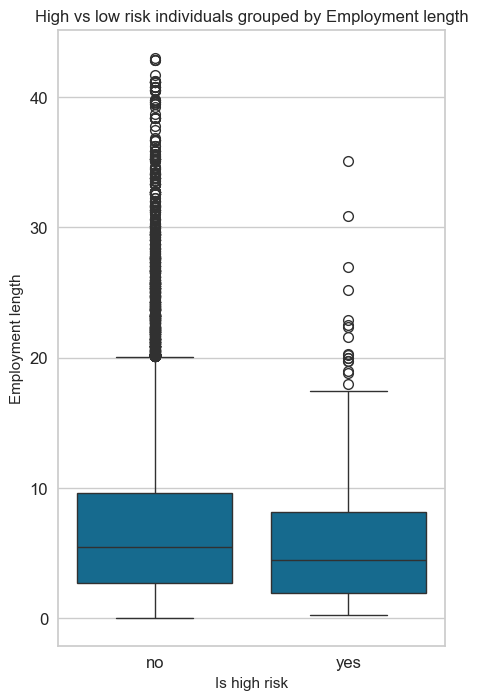

In [252]:
# So sánh giữa hai đặc trưng Employment length và IsHighRisk (độ rủi ro dựa vào thời gian làm việc)
low_high_risk_box_plot(cc_train_copy, 'Employment length', cc_train_copy)

### Đặc trưng Has a car (có xe riêng)

In [253]:
# Phân tích đơn biến Has a car
gen_info_feat(cc_train_copy, 'Has a car', cc_train_copy)

Description:
count     29165
unique        2
top           N
freq      18128
Name: Has a car, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
           Count  Frequency (%)
Has a car                      
N          18128          62.16
Y          11037          37.84


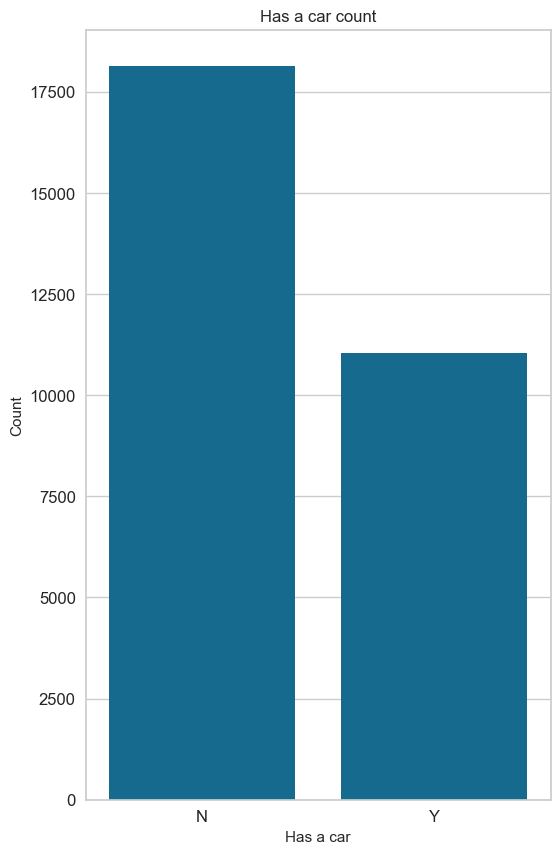

In [254]:
# Vẽ biểu đồ hộp
create_bar_plot(cc_train_copy, 'Has a car')

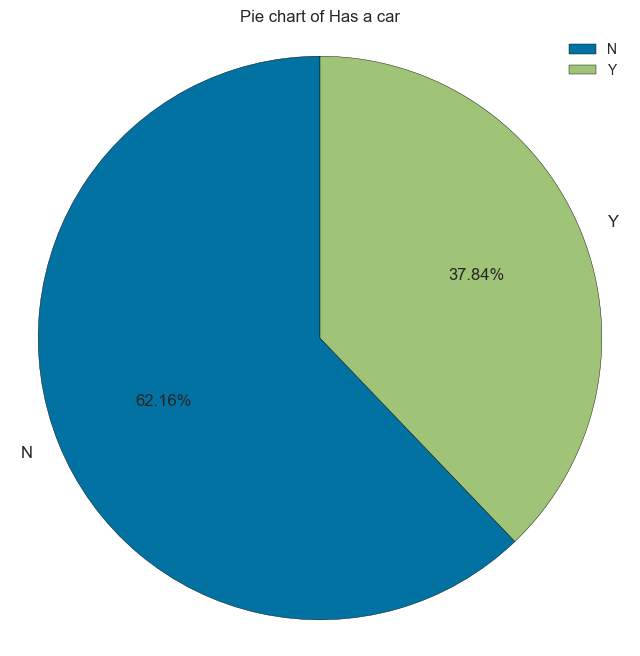

In [255]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Has a car')

### Đặc trưng Has a property (sở hữu tài sản)

In [256]:
# Phân tích đơn biến
gen_info_feat(cc_train_copy, 'Has a property', cc_train_copy)

Description:
count     29165
unique        2
top           Y
freq      19557
Name: Has a property, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                Count  Frequency (%)
Has a property                      
Y               19557          67.06
N                9608          32.94


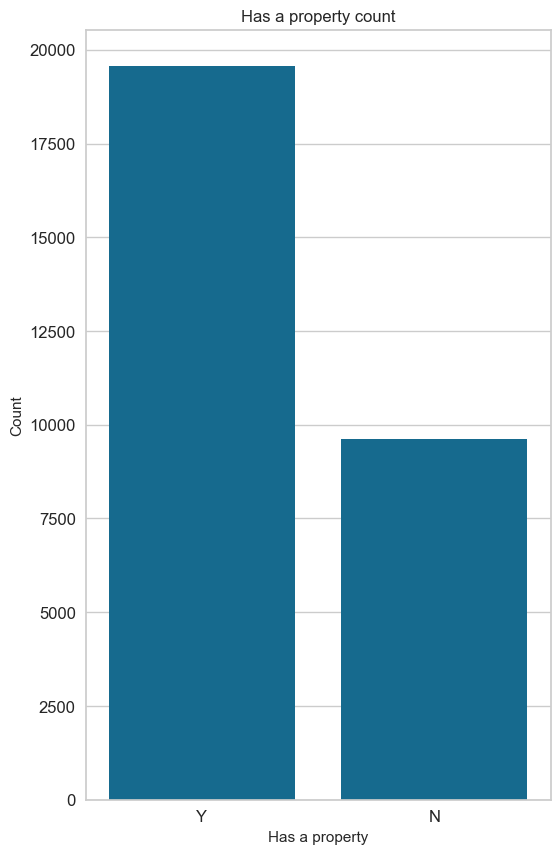

In [257]:
# Vẽ biểu đồ cột 
create_bar_plot(cc_train_copy, 'Has a property')

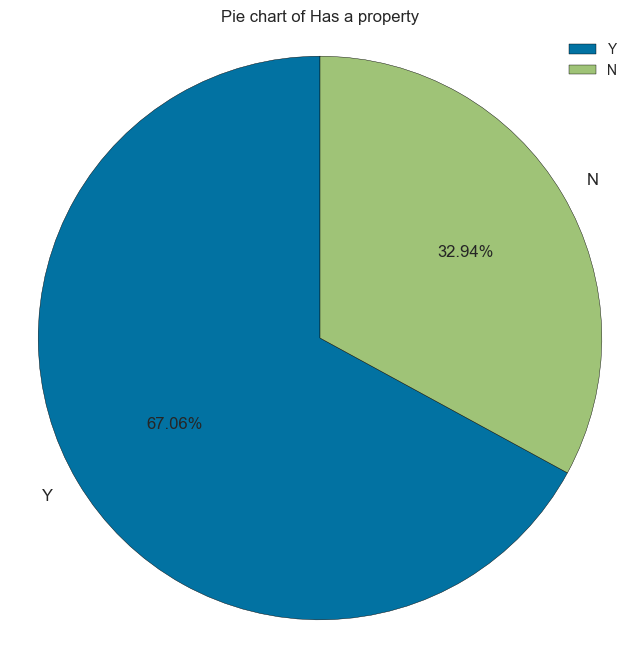

In [258]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Has a property')

### Đặc trưng Has a work phone (có điện thoại cơ quan)

In [259]:
# Phân tích đơn biến Has a work phone
gen_info_feat(cc_train_copy, 'Has a work phone', cc_train_copy)

Description:
count   29165.00
mean        0.22
std         0.42
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has a work phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                  Count  Frequency (%)
Has a work phone                      
0                 22623          77.57
1                  6542          22.43


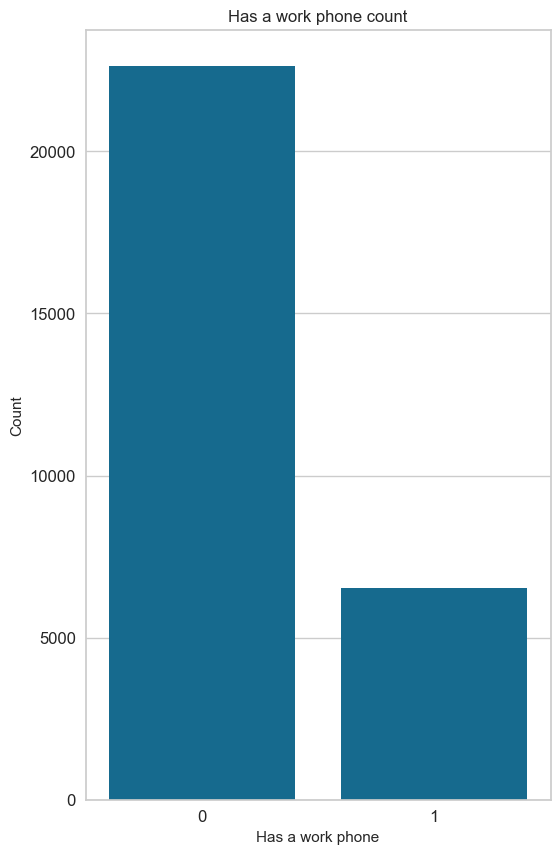

In [260]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Has a work phone')

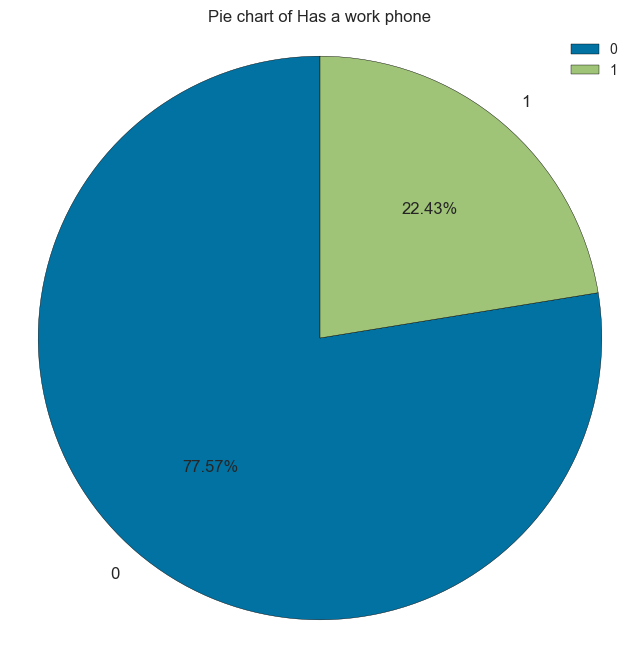

In [261]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Has a work phone')

### Đặc trưng Has a mobile phone (có điện thoại di động)

In [262]:
# Phân tích đơn biến Has a mobile phone
gen_info_feat(cc_train_copy, 'Has a mobile phone', cc_train_copy)

Description:
count   29165.00
mean        1.00
std         0.00
min         1.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: Has a mobile phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
                    Count  Frequency (%)
Has a mobile phone                      
1                   29165         100.00


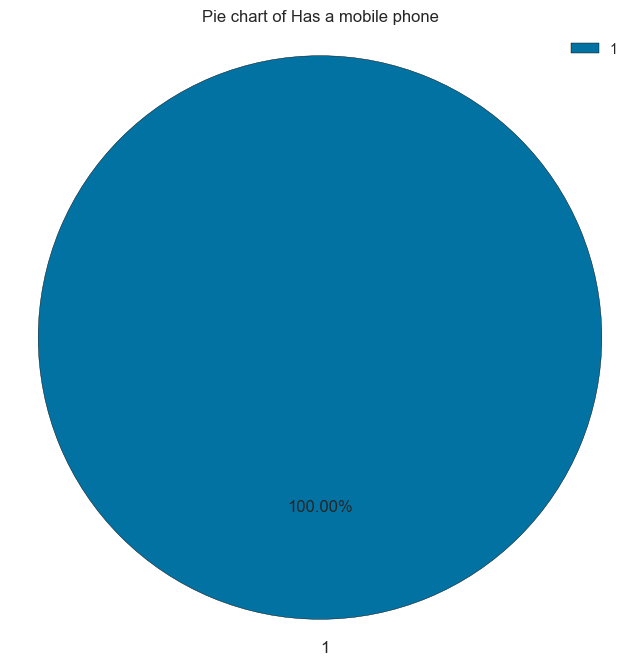

In [263]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Has a mobile phone')

### Đặc trưng Has a phone (điện thoại nhà riêng)

In [264]:
# Phân tích đơn biến Has a phone 
gen_info_feat(cc_train_copy, 'Has a phone', cc_train_copy)

Description:
count   29165.00
mean        0.29
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Has a phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
             Count  Frequency (%)
Has a phone                      
0            20562          70.50
1             8603          29.50


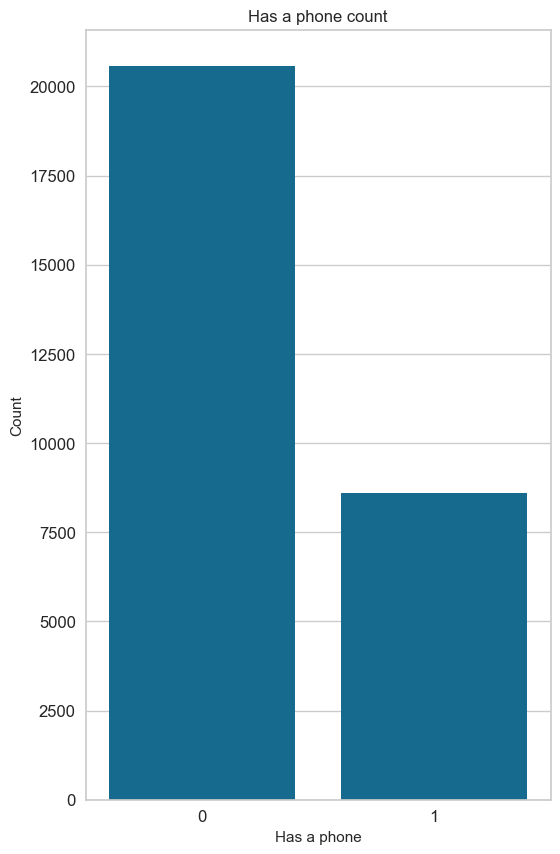

In [265]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Has a phone')

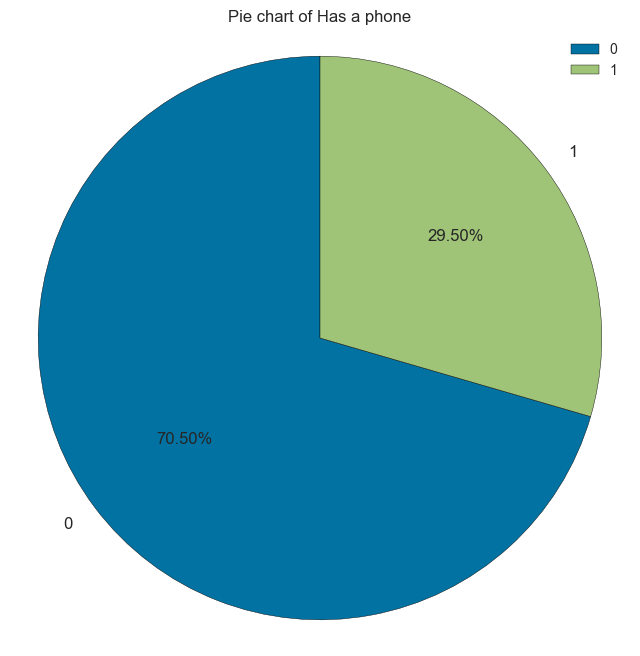

In [266]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Has a phone')

### Đặc trưng Has an email (có địa chỉ email)

In [267]:
# Phân tích đơn biến Has an email
gen_info_feat(cc_train_copy, 'Has an email', cc_train_copy)

Description:
count   29165.00
mean        0.09
std         0.29
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has an email, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
              Count  Frequency (%)
Has an email                      
0             26532          90.97
1              2633           9.03


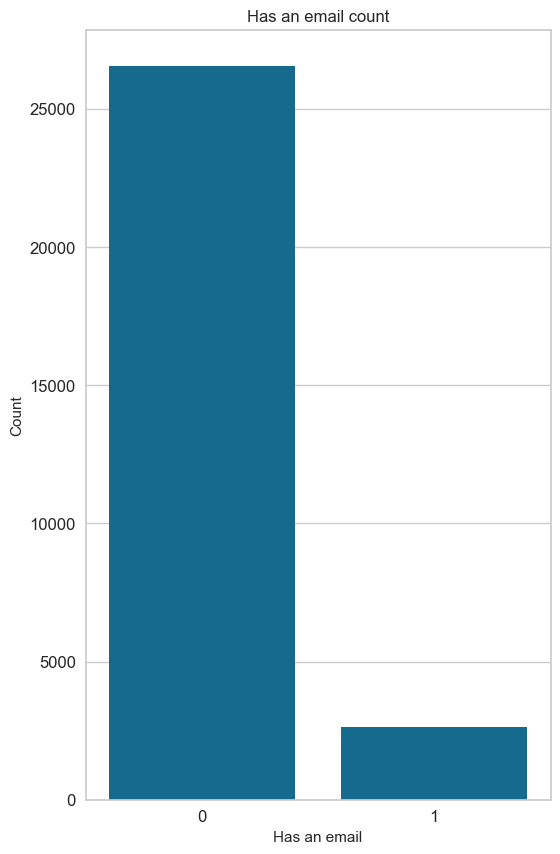

In [268]:
# Vẽ biểu đồ cột 
create_bar_plot(cc_train_copy, 'Has an email')

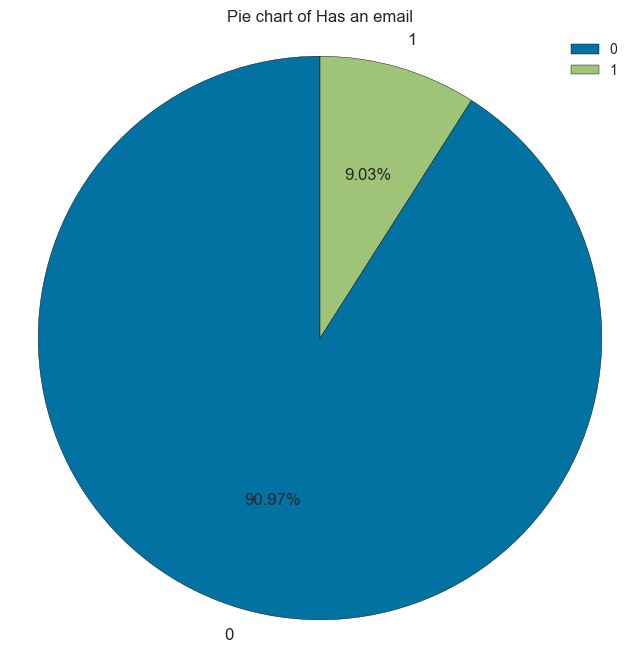

In [269]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Has an email')

### Đặc trưng Account age (tuổi tài khoản)

In [270]:
# Phân tích đơn biến Account age
gen_info_feat(cc_train_copy, 'Account age', cc_train_copy)

Description:
count   29165.00
mean       26.14
std        16.49
min         0.00
25%        12.00
50%        24.00
75%        39.00
max        60.00
Name: Account age, dtype: float64
**************************************************
Object type:float64


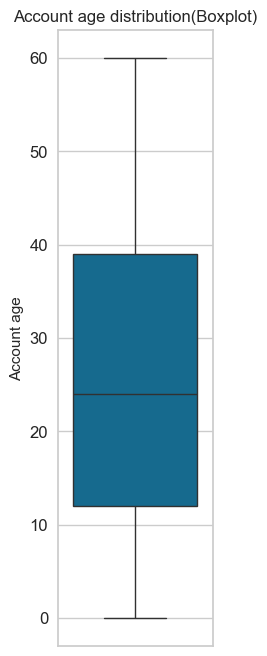

In [271]:
# Vẽ biểu đồ hộp
create_box_plot(cc_train_copy, 'Account age', cc_train_copy)

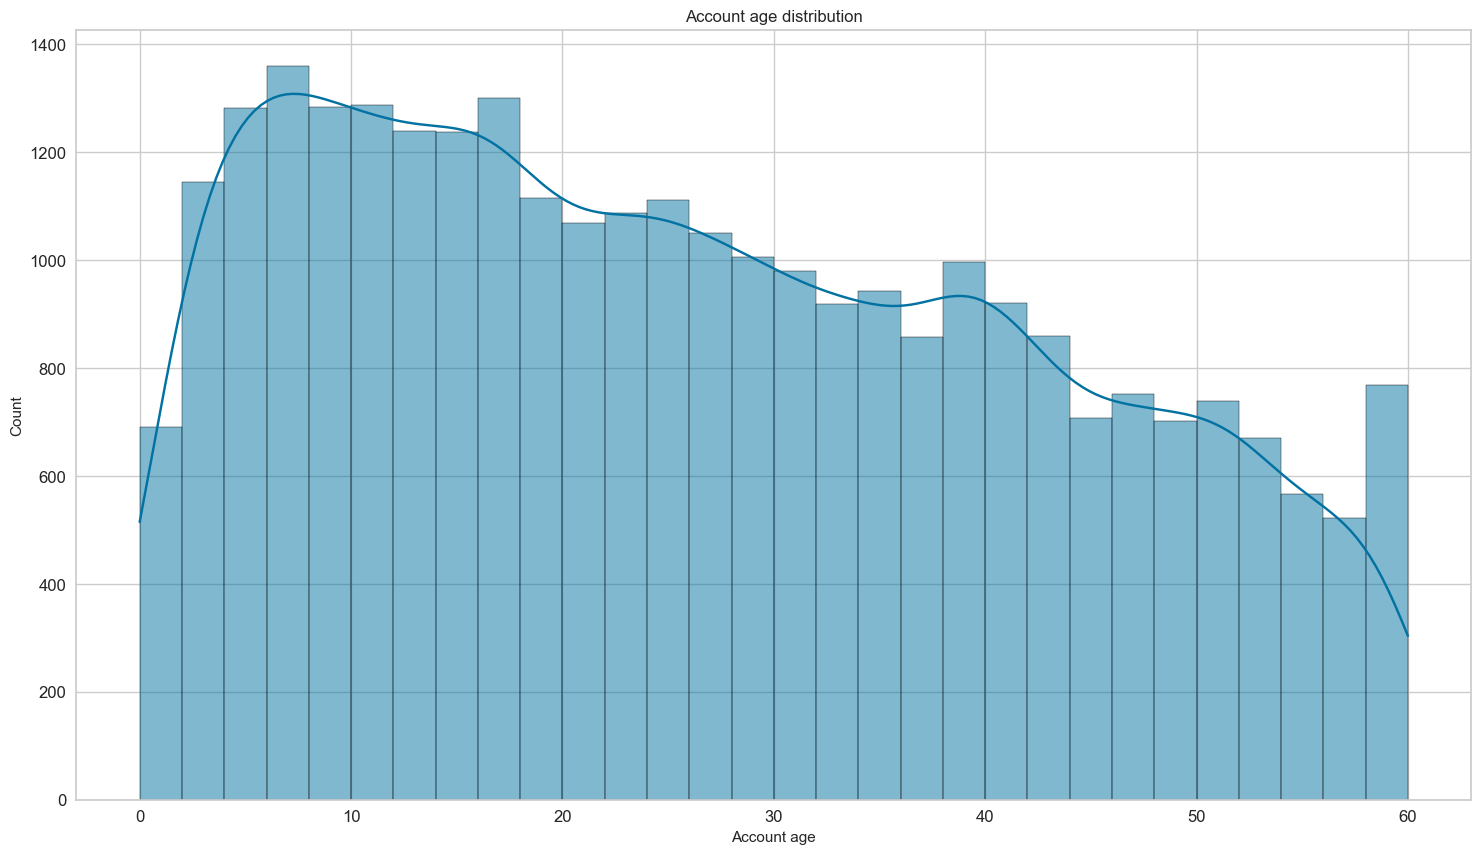

In [272]:
# Vẽ biểu đồ histogram
create_hist_plot(cc_train_copy, 'Account age', cc_train_copy, the_bins=30)

Is high risk
0   26.00
1   34.04
Name: Account age, dtype: float64


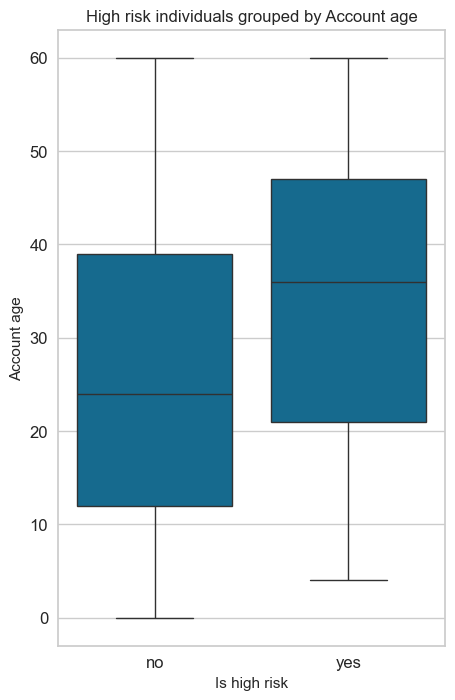

In [273]:
# So sánh giữa hai đặc trưng Account age và IsHighRisk (độ rủi ro dựa vào độ tuổi tài khoản)
low_high_risk_box_plot(cc_train_copy, 'Account age', cc_train_copy)

### Đặc trưng biến mục tiêu Is High Risk 

In [274]:
# Phân tích đơn biến Is high risk (dữ liệu cần cân bằng SMOTE trước khi training model)
gen_info_feat(cc_train_copy, 'Is high risk', cc_train_copy)

Description:
count     29165
unique        2
top           0
freq      28666
Name: Is high risk, dtype: int64
**************************************************
Object type:
object
**************************************************
Value count:
              Count  Frequency (%)
Is high risk                      
0             28666          98.29
1               499           1.71


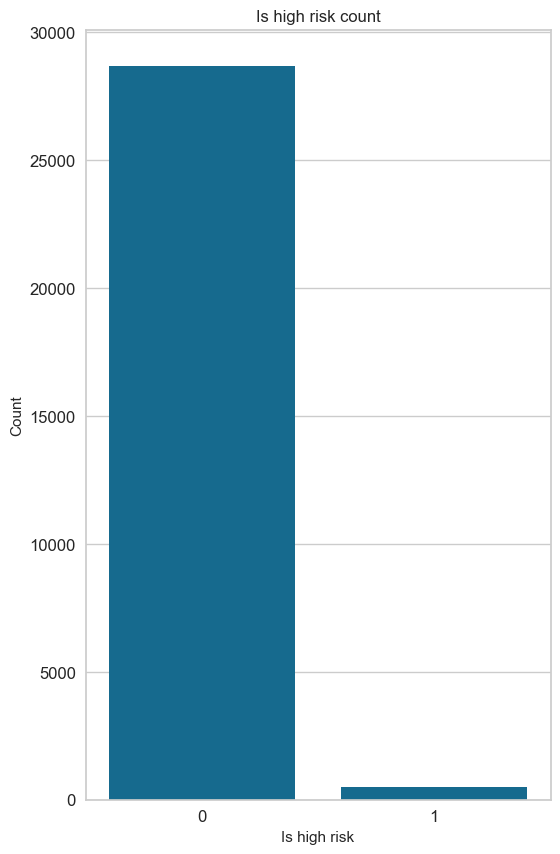

In [275]:
# Vẽ biểu đồ cột
create_bar_plot(cc_train_copy, 'Is high risk')

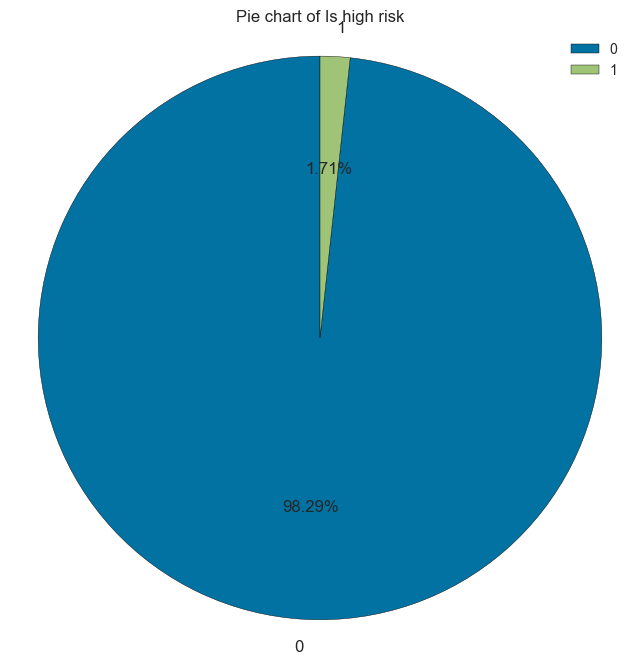

In [276]:
# Vẽ biểu đồ tròn
create_pie_plot(cc_train_copy, 'Is high risk')

## Phân tích hai biến

#### 1. Trực quan hóa biểu đồ theo từng cặp:

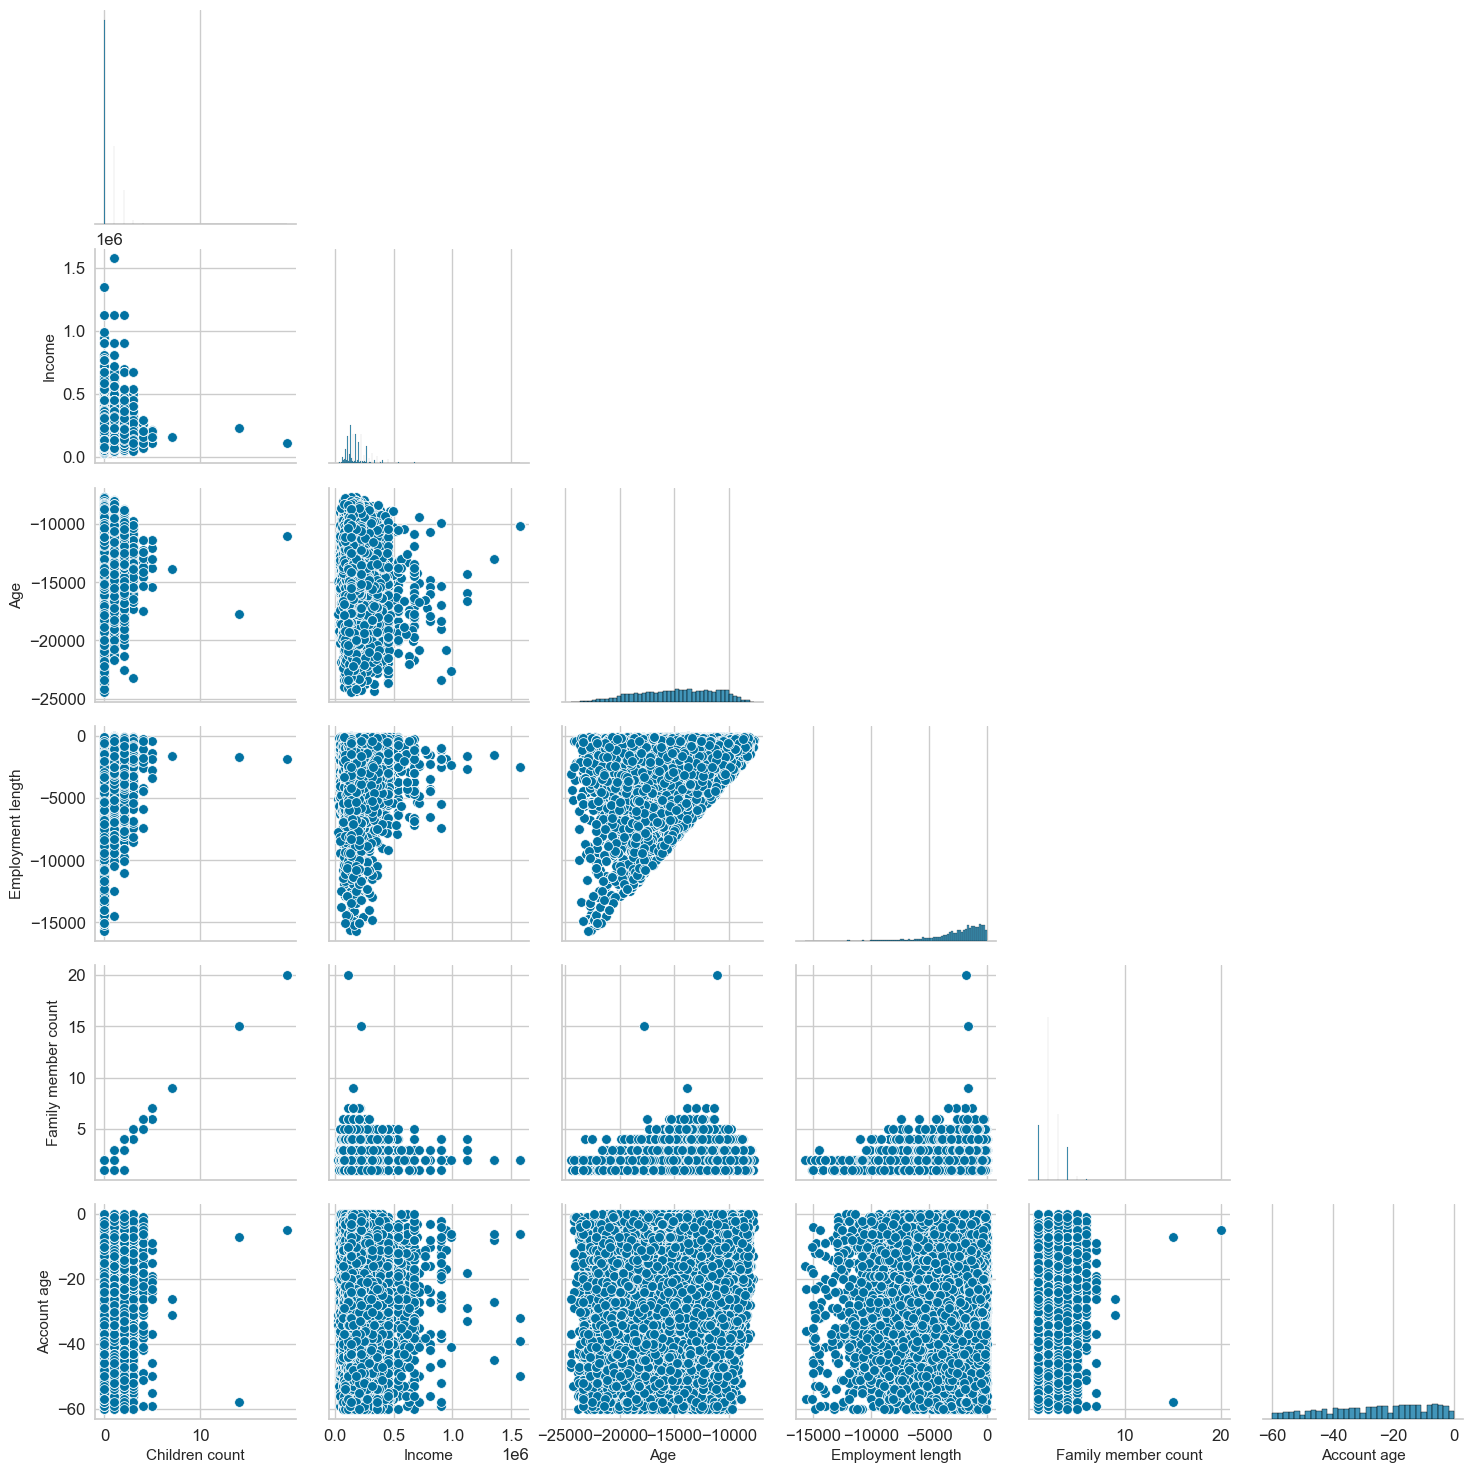

In [277]:
# Xóa một số đặc trưng không phù hợp để huấn luyện mô hình (So sánh từng cặp biến)
sns.pairplot(cc_train_copy[cc_train_copy['Employment length'] < 0].drop(['ID', 'Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email', 'Is high risk'], axis=1), corner=True)
plt.show()

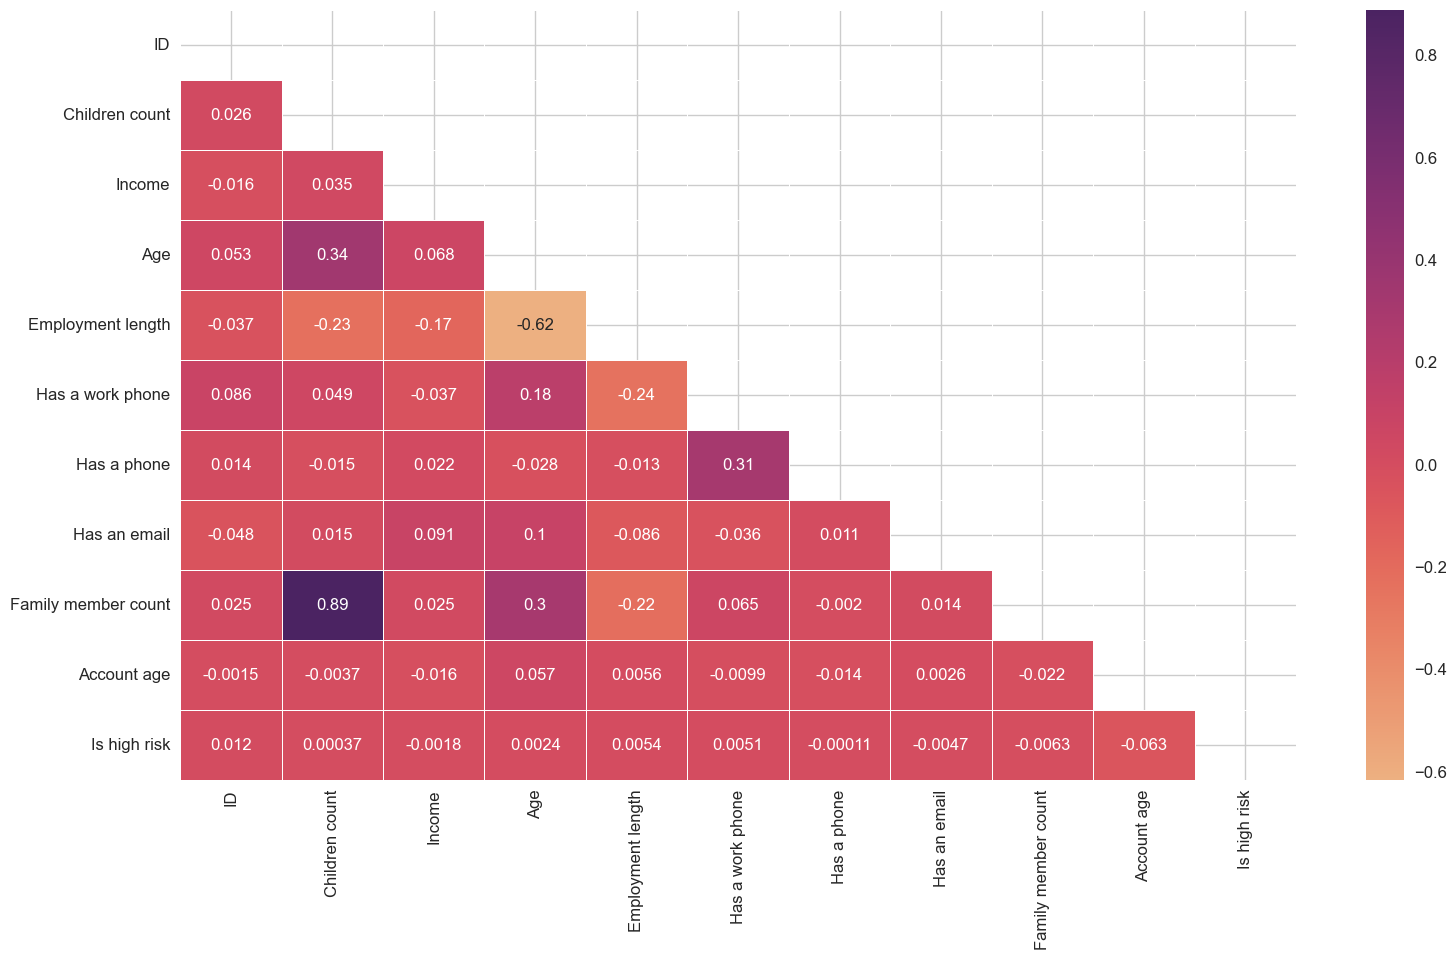

In [278]:
# Heatmap cho các dữ liệu dạng Numeric
cc_train_copy['Is high risk'] = cc_train_copy['Is high risk'].astype('int32')

# Chỉ giữ lại các cột số
cc_train_numeric = cc_train_copy.select_dtypes(include=['number'])

# Tính ma trận tương quan không chứa "Has a mobile phone" (thuộc tính không quan trọng trong phân tích đa biến)
cc_train_copy_corr_no_mobile = cc_train_numeric.drop(columns=['Has a mobile phone'], errors='ignore').corr()

# Tạo mask cho ma trận tam giác dưới
mask = np.triu(np.ones_like(cc_train_copy_corr_no_mobile, dtype=bool))

# Vẽ heatmap
fig, ax = plt.subplots(figsize=(18,10))
sns.heatmap(cc_train_copy_corr_no_mobile, annot=True, cmap='flare', mask=mask, linewidths=.5)
plt.show()

#### 2. Mối quan hệ tuyến tính dương giữa các cặp biến:

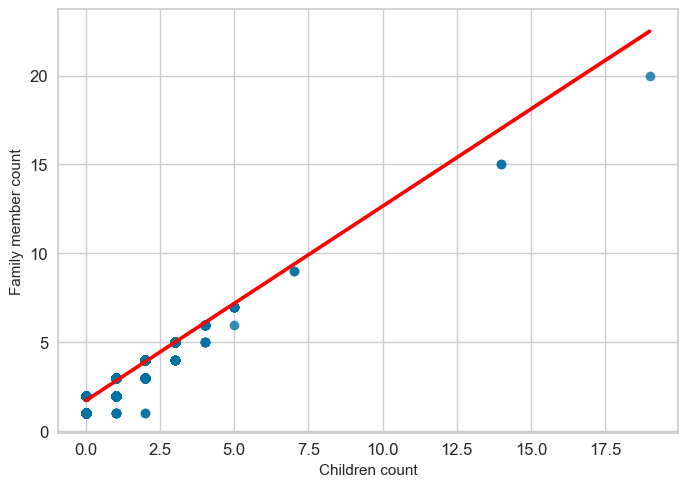

In [279]:
# Mối quan hệ giữa "Children count" và "Family member count" (cần loại bỏ 1 trong 2 đặc trưng đi)
sns.regplot(x='Children count', y='Family member count', data=cc_train_copy,line_kws={'color': 'red'})
plt.show()

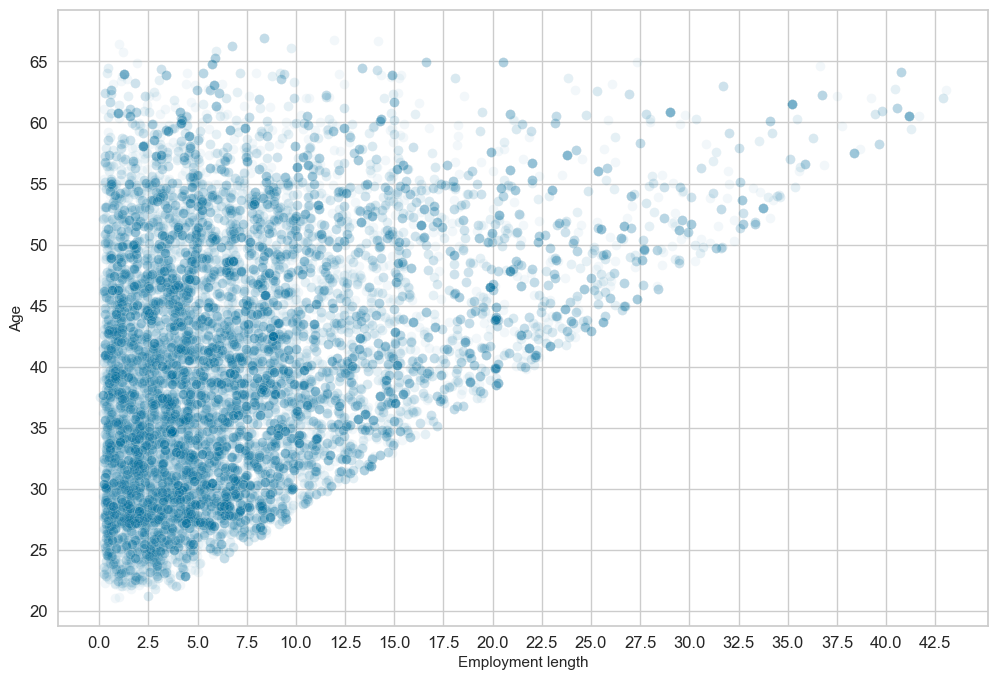

In [280]:
# Mối quan hệ giữa "Age" và "Employment Length" (cần loại bỏ 1 trong 2 đặc trưng đi)
y_age = np.abs(cc_train_copy['Age'])/365.25
x_employ_length = np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length'])/365.25

# Thay đổi giá trị của biểu đồ
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x = x_employ_length, y = y_age, alpha = 0.05)

plt.xticks(np.arange(0, x_employ_length.max(), 2.5))
plt.yticks(np.arange(20, y_age.max(), 5))
plt.show()

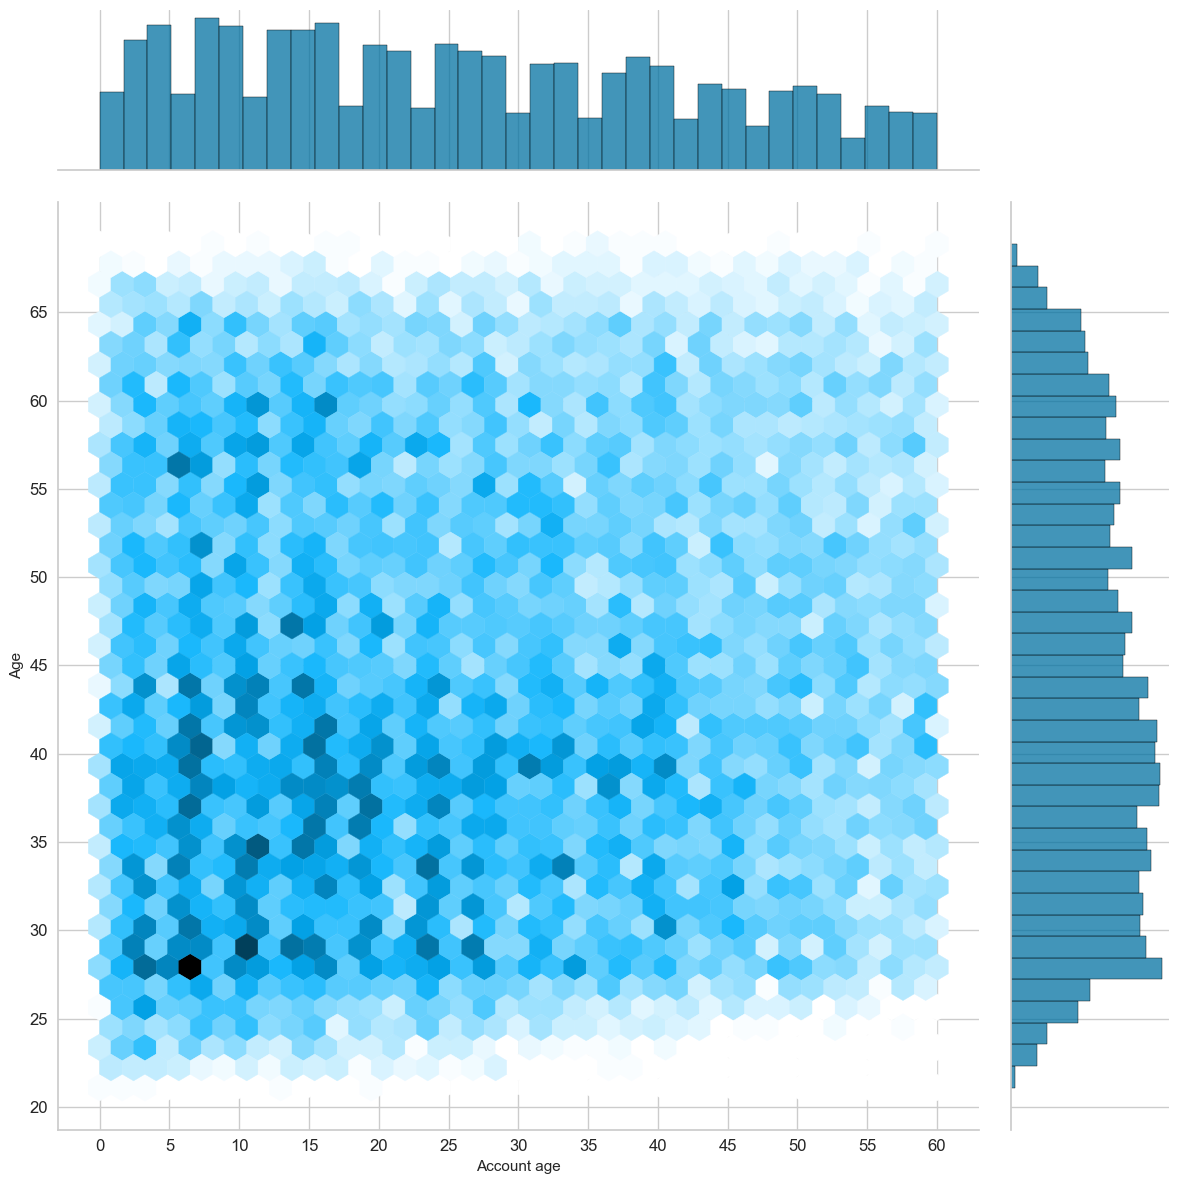

In [281]:
# Mối quan hệ giữa "Age" và "Account Age" 
sns.jointplot(x = np.abs(cc_train_copy['Account age']), y = y_age, kind = "hex", height = 12)
plt.yticks(np.arange(20, y_age.max(), 5))
plt.xticks(np.arange(0, 65, 5))
plt.ylabel('Age')
plt.show()

## Phân tích phương sai

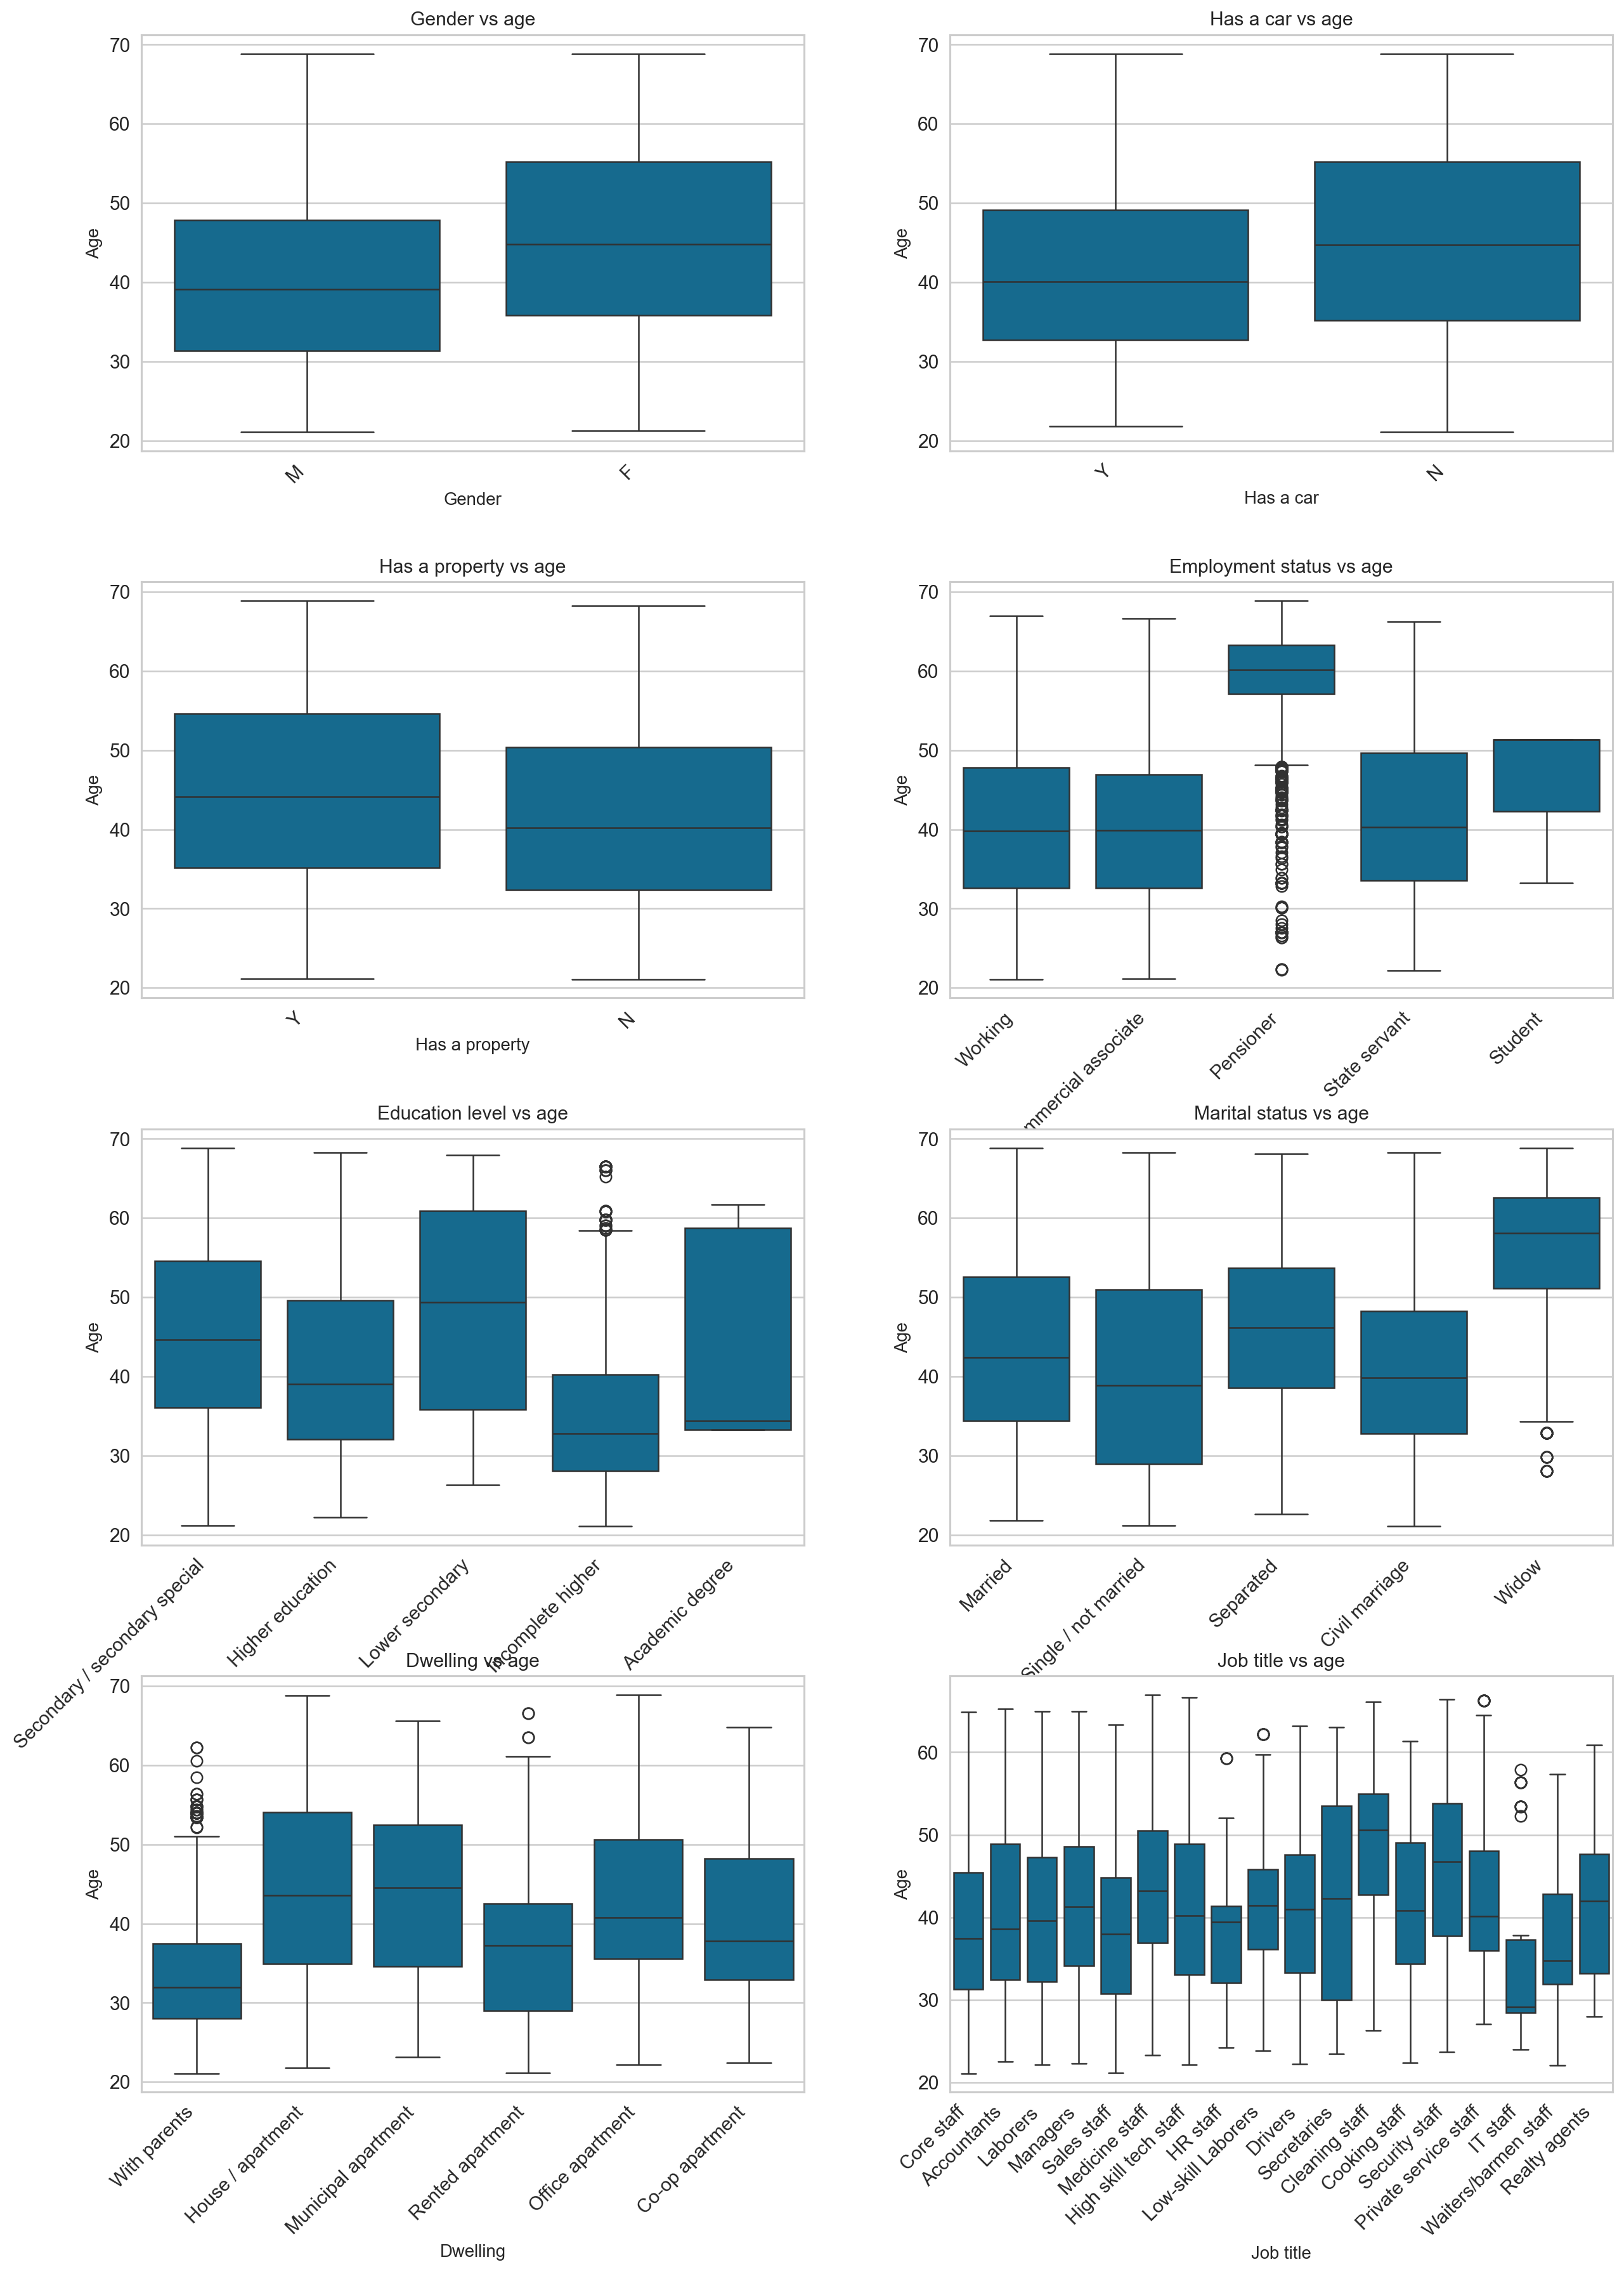

In [282]:
# Đặc trưng "Age" với các đặc trưng còn lại
fig, axes = plt.subplots(4, 2, figsize=(15,20), dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy['Age'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Age')
            cat_ft_count += 1
    break

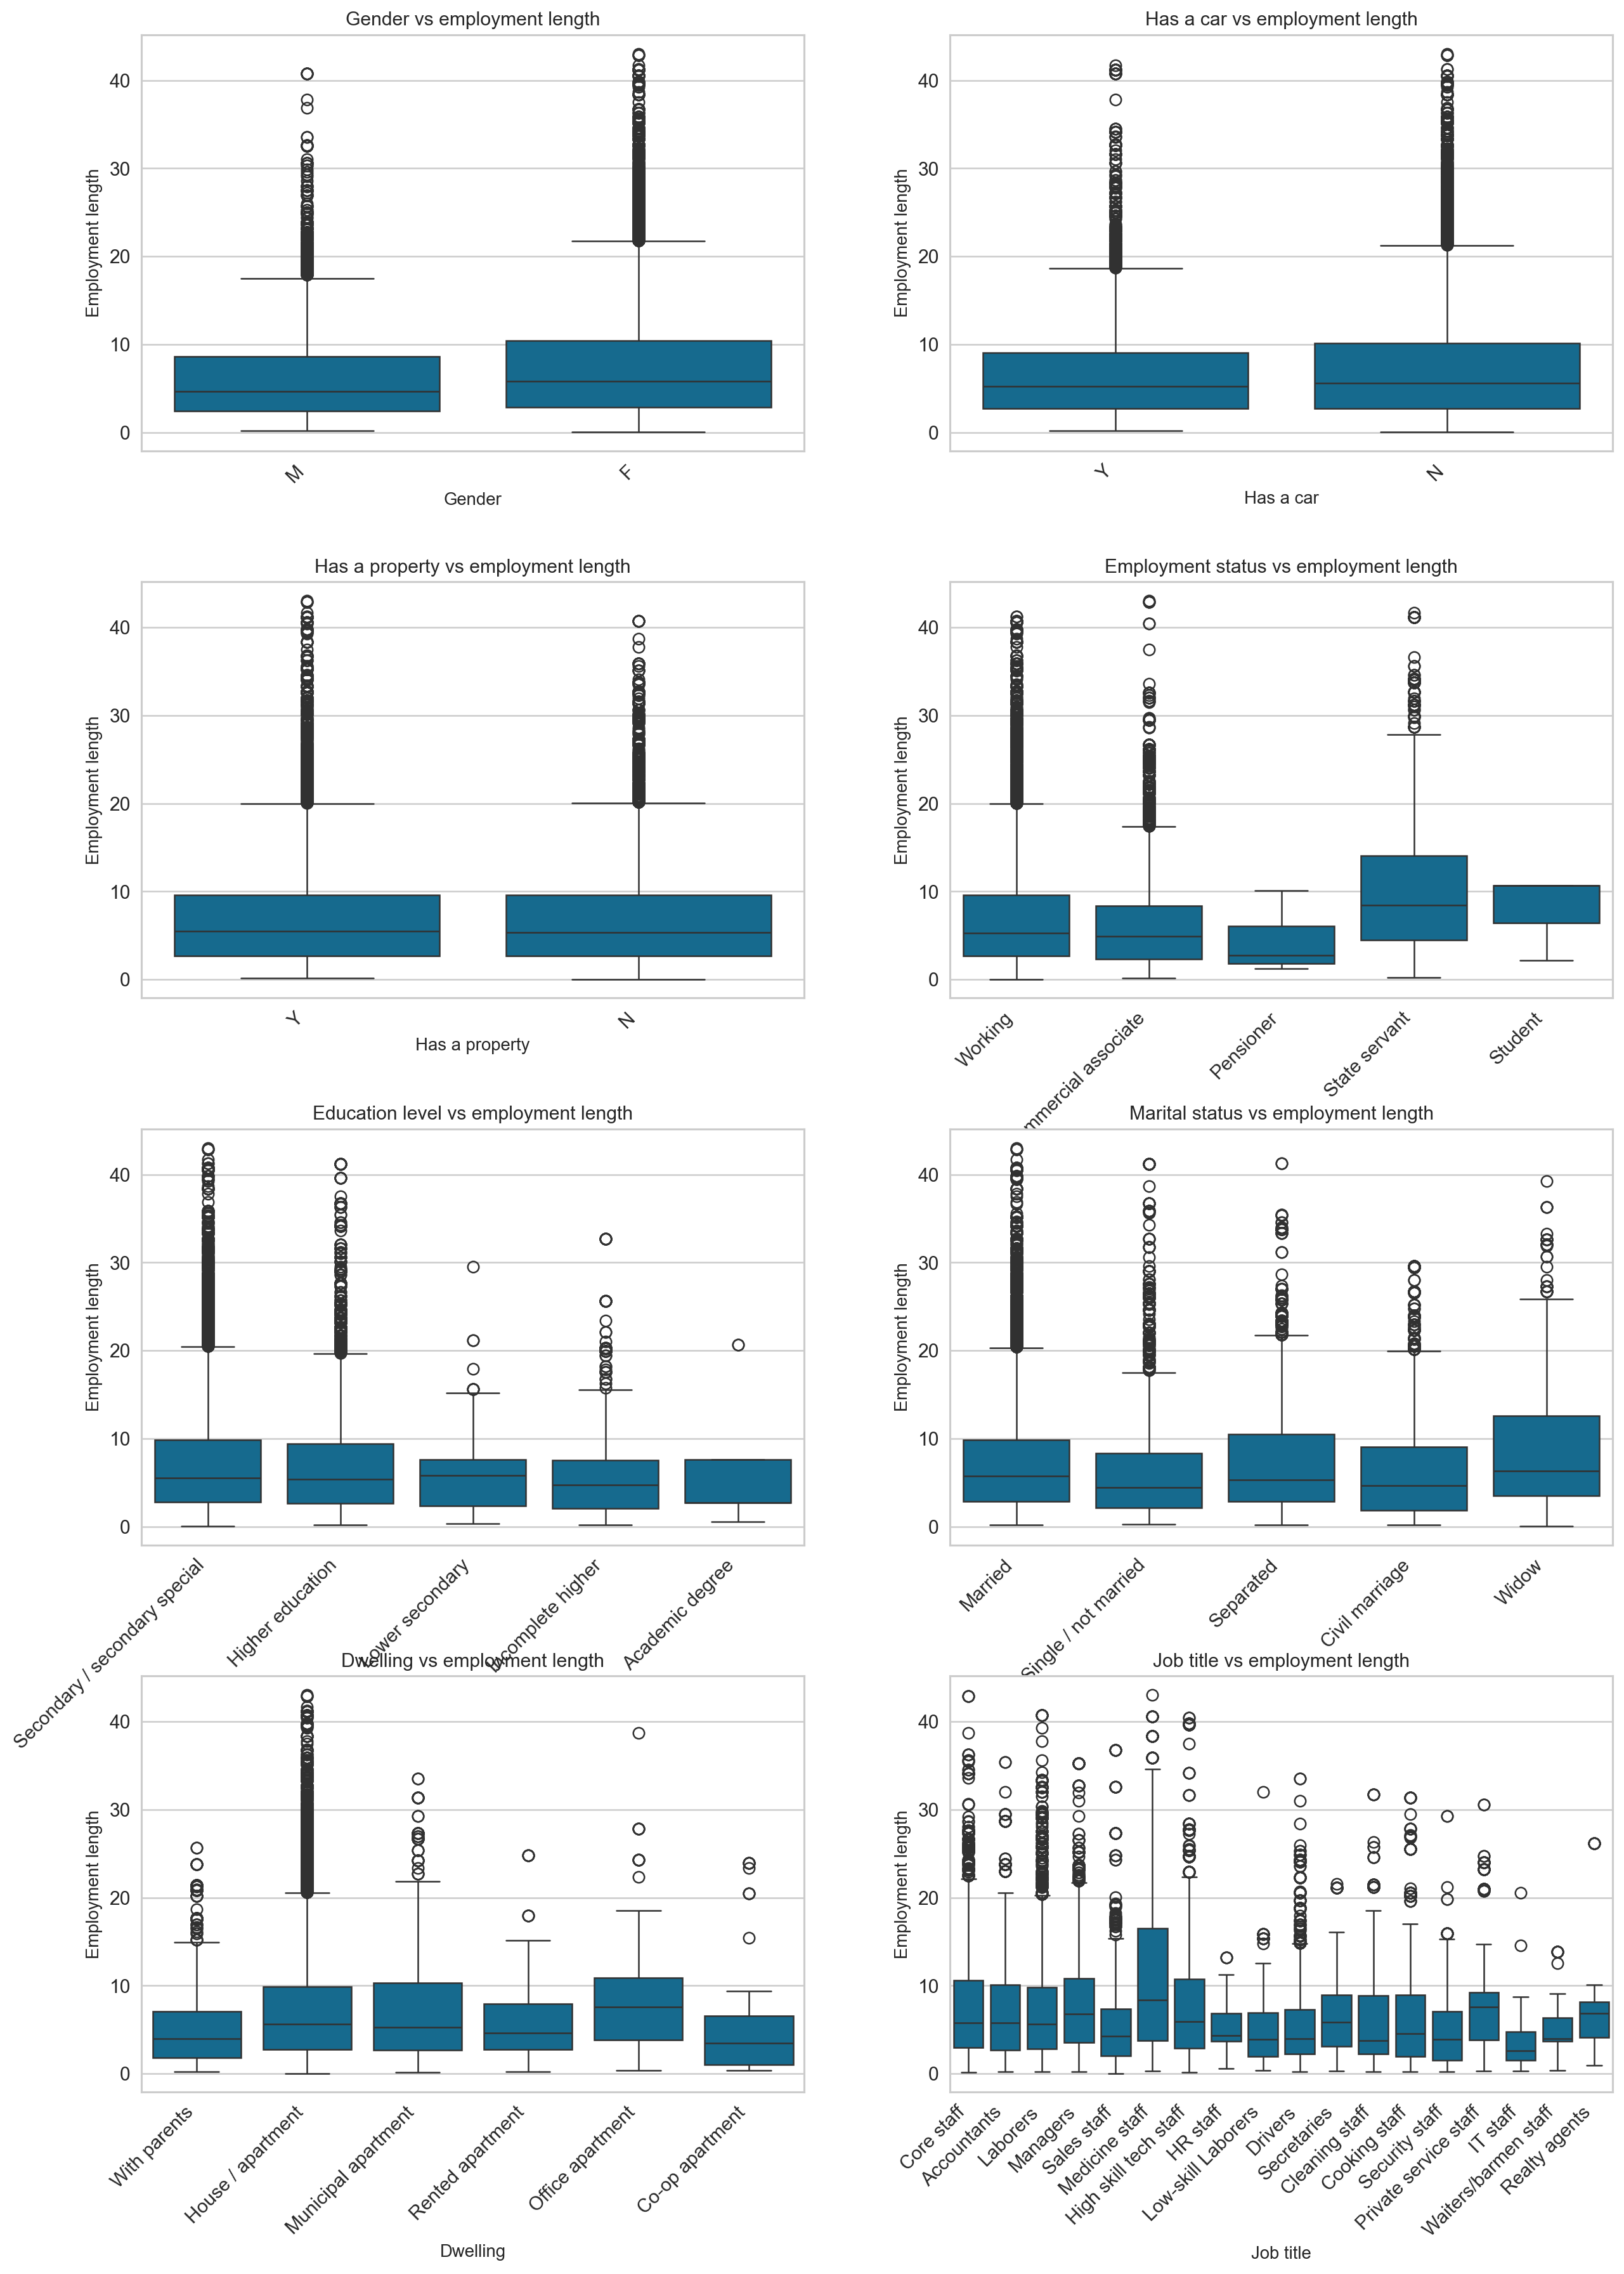

In [283]:
# Đặc trưng "Employment length" với các đặc trưng còn lại
fig, axes = plt.subplots(4, 2, figsize=(15,20), dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs employment length")
            plt.sca(axes[row_count,feat_count])
            plt.ylabel('Employment length')
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

# Data Preprocessing

In [284]:
from machine_learning.data_preprocessing import full_pipeline

In [285]:
pd.options.mode.chained_assignment = None           # Hide the warnings
cc_train_prep = full_pipeline(cc_train_copy)

In [286]:
print(f"Dim = {cc_train_prep.shape}")

Dim = (46544, 34)


In [287]:
# Show Preprocessing Data
pd.set_option('display.max_columns', None)
cc_train_prep.head()

Gender_F  Gender_M  Marital status_Civil marriage  Marital status_Married  \
0      0.00      1.00                           0.00                    1.00   
1      1.00      0.00                           0.00                    0.00   
2      1.00      0.00                           0.00                    1.00   
3      1.00      0.00                           0.00                    0.00   
4      1.00      0.00                           0.00                    0.00   

   Marital status_Separated  Marital status_Single / not married  \
0                      0.00                                 0.00   
1                      0.00                                 1.00   
2                      0.00                                 0.00   
3                      0.00                                 1.00   
4                      1.00                                 0.00   

   Marital status_Widow  Dwelling_Co-op apartment  Dwelling_House / apartment  \
0                  0.00                      0.00                        0.00   
1                  0.00                      0.00                        1.00   
2                  0.00                      0.00                        1.00   
3                  0.00                      0.00                        1.00   
4                  0.00                      0.00                        1.00   

   Dwelling_Municipal apartment  Dwelling_Office apartment  \
0                          0.00                       0.00   
1                          0.00                       0.00   
2                          0.00                       0.00   
3                          0.00                       0.00   
4                          0.00                       0.00   

   Dwelling_Rented apartment  Dwelling_With parents  \
0                       0.00                   1.00   
1                       0.00                   0.00   
2                       0.00                   0.00   
3                       0.00                   0.00   
4                       0.00                   0.00   

   Employment status_Commercial associate  Employment status_Pensioner  \
0                                    0.00                         0.00   
1                                    1.00                         0.00   
2                                    1.00                         0.00   
3                                    1.00                         0.00   
4                                    0.00                         0.00   

   Employment status_State servant  Employment status_Student  \
0                             0.00                       0.00   
1                             0.00                       0.00   
2                             0.00                       0.00   
3                             0.00                       0.00   
4                             0.00                       0.00   

   Employment status_Working  Has a car_N  Has a car_Y  Has a property_N  \
0                       1.00         0.00         1.00              0.00   
1                       0.00         0.00         1.00              1.00   
2                       0.00         1.00         0.00              0.00   
3                       0.00         0.00         1.00              0.00   
4                       1.00         1.00         0.00              1.00   

   Has a property_Y  Has a work phone_N  Has a work phone_Y  Has a phone_N  \
0              1.00                1.00                0.00           1.00   
1              0.00                1.00                0.00           1.00   
2              1.00                1.00                0.00           1.00   
3              1.00                1.00                0.00           1.00   
4              0.00                1.00                0.00           0.00   

   Has a phone_Y  Has an email_N  Has an email_Y  Income  Education level  \
0           0.00            1.00            0.00    0.42             4.00   
1     

In [288]:
# Extract the target variable "Is high risk" for training model
X_cc_train_prep, y_cc_train_prep = cc_train_prep.loc[:, cc_train_prep.columns != 'Is high risk'], cc_train_prep['Is high risk'].astype('int64')

In [289]:
# Xtrain for Model
X_cc_train_prep.head()

Gender_F  Gender_M  Marital status_Civil marriage  Marital status_Married  \
0      0.00      1.00                           0.00                    1.00   
1      1.00      0.00                           0.00                    0.00   
2      1.00      0.00                           0.00                    1.00   
3      1.00      0.00                           0.00                    0.00   
4      1.00      0.00                           0.00                    0.00   

   Marital status_Separated  Marital status_Single / not married  \
0                      0.00                                 0.00   
1                      0.00                                 1.00   
2                      0.00                                 0.00   
3                      0.00                                 1.00   
4                      1.00                                 0.00   

   Marital status_Widow  Dwelling_Co-op apartment  Dwelling_House / apartment  \
0                  0.00                      0.00                        0.00   
1                  0.00                      0.00                        1.00   
2                  0.00                      0.00                        1.00   
3                  0.00                      0.00                        1.00   
4                  0.00                      0.00                        1.00   

   Dwelling_Municipal apartment  Dwelling_Office apartment  \
0                          0.00                       0.00   
1                          0.00                       0.00   
2                          0.00                       0.00   
3                          0.00                       0.00   
4                          0.00                       0.00   

   Dwelling_Rented apartment  Dwelling_With parents  \
0                       0.00                   1.00   
1                       0.00                   0.00   
2                       0.00                   0.00   
3                       0.00                   0.00   
4                       0.00                   0.00   

   Employment status_Commercial associate  Employment status_Pensioner  \
0                                    0.00                         0.00   
1                                    1.00                         0.00   
2                                    1.00                         0.00   
3                                    1.00                         0.00   
4                                    0.00                         0.00   

   Employment status_State servant  Employment status_Student  \
0                             0.00                       0.00   
1                             0.00                       0.00   
2                             0.00                       0.00   
3                             0.00                       0.00   
4                             0.00                       0.00   

   Employment status_Working  Has a car_N  Has a car_Y  Has a property_N  \
0                       1.00         0.00         1.00              0.00   
1                       0.00         0.00         1.00              1.00   
2                       0.00         1.00         0.00              0.00   
3                       0.00         0.00         1.00              0.00   
4                       1.00         1.00         0.00              1.00   

   Has a property_Y  Has a work phone_N  Has a work phone_Y  Has a phone_N  \
0              1.00                1.00                0.00           1.00   
1              0.00                1.00                0.00           1.00   
2              1.00                1.00                0.00           1.00   
3              1.00                1.00                0.00           1.00   
4              0.00                1.00                0.00           0.00   

   Has a phone_Y  Has an email_N  Has an email_Y  Income  Education level  \
0           0.00            1.00            0.00    0.42             4.00   
1     

In [290]:
# Ytrain for Model
y_cc_train_prep.head()

0    0
1    0
2    0
3    0
4    0
Name: Is high risk, dtype: int64

# Training Models

In [295]:
from machine_learning.models import classifiers, folder_check_model
from machine_learning.training_models import train_model, score_func
from machine_learning.plot_models import roc_curve_func, confusion_matrix_func, feat_importance_plot





----------------------  sgd  ----------------------


              precision    recall  f1-score   support

           0       0.56      0.61      0.58     23272
           1       0.57      0.52      0.54     23272

    accuracy                           0.57     46544
   macro avg       0.57      0.57      0.56     46544
weighted avg       0.57      0.57      0.56     46544



TypeError: y_prediction_func() missing 2 required positional arguments: 'X_cc_train_prep' and 'y_cc_train_prep'

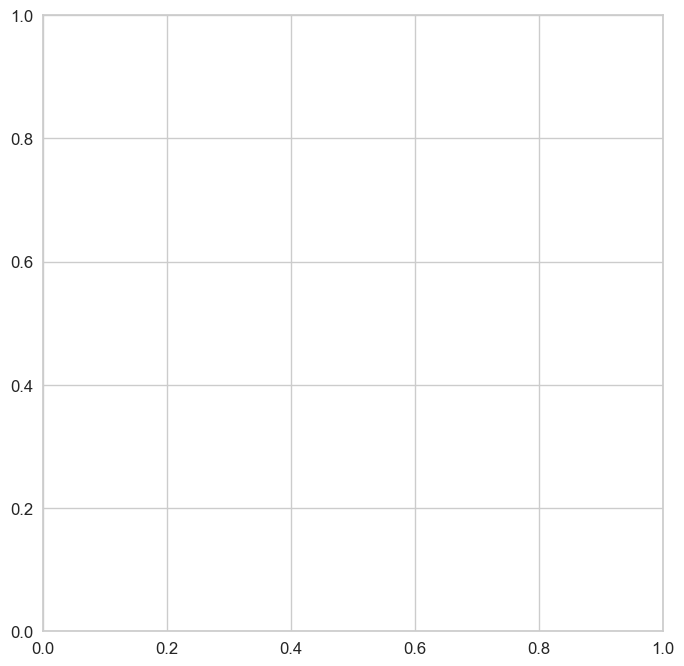

In [ ]:
# Run the models
for model_name, model in classifiers.items():
    # Title formatting
    print('\n')
    print('\n')
    print('  {}  '.center(50,'-').format(model_name))
    print('\n')
    folder_check_model(model_name)
    
    # Training the model
    model_trn = train_model(model, model_name, X_cc_train_prep, y_cc_train_prep)
    score_func(model_trn, model_name, X_cc_train_prep, y_cc_train_prep)

    # Plot the ROC curve, Confusion matrix, Feature importance
    roc_curve_func(model_trn, model_name, X_cc_train_prep, y_cc_train_prep)
    confusion_matrix_func(model_trn, model_name, y_cc_train_prep)
    feat_importance_plot(model_trn, model_name, X_cc_train_prep, y_cc_train_prep)
    warnings.filterwarnings("ignore")